# Cell 1: Imports and Setup

This cell imports all necessary libraries for the algorithmic trading bot.

Key Components:
- Core libraries: pandas, numpy, datetime
- ML libraries: sklearn, xgboost, tensorflow
- Trading: alpaca-py
- Utilities: tqdm for progress, logging for monitoring
- Visualization: matplotlib, seaborn

Setup:
- Suppress warnings for clean output
- Configure matplotlib for inline plotting
- Set random seeds for reproducible results

In [17]:
# ============================================================================
# ALGORITHMIC TRADING BOT - CELL 1: IMPORTS AND SETUP
# ============================================================================

# Core Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import pickle
import logging
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Any
from abc import ABC, abstractmethod
import json

# Environment and Configuration
from dotenv import load_dotenv
load_dotenv()

# Trading API (alpaca-py)
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest, GetOrdersRequest
from alpaca.trading.enums import OrderSide, TimeInForce

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Deep Learning (TensorFlow/Keras will be imported only in the LSTM cell)
# import tensorflow as tf
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# tf.get_logger().setLevel('ERROR')  # Suppress TF warnings

# Technical Analysis
import talib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import ipywidgets as widgets
%matplotlib inline

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Random seeds for reproducibility
np.random.seed(42)
# tf.random.set_seed(42)  # Only set in LSTM cell if needed

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('bot.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

print("All imports loaded successfully!")
# print(f"TensorFlow version: {tf.__version__}")  # Only print in LSTM cell
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All imports loaded successfully!
Pandas version: 2.1.4
NumPy version: 1.26.2


# Cell 2: Configuration

This cell defines all configuration parameters using a dataclass for clean organization.

Key Features:
- Environment variable loading with python-dotenv
- Risk management parameters
- Trading universe (15 liquid symbols)
- ML model parameters
- Operational settings

Security:
- API credentials loaded from environment variables
- Paper trading mode enabled by default

In [18]:
# ============================================================================
# CELL 2: CONFIGURATION
# ============================================================================

@dataclass
class TradingConfig:
    """Configuration class for algorithmic trading bot"""
    
    # API Configuration
    ALPACA_API_KEY: str = os.getenv('ALPACA_API_KEY')
    ALPACA_SECRET_KEY: str = os.getenv('ALPACA_SECRET_KEY')
    ALPACA_BASE_URL: str = 'https://paper-api.alpaca.markets/v2'  # Paper trading
    
    # Portfolio Settings
    INITIAL_CAPITAL: float = 100000.0  # $100K paper trading
    MAX_POSITION_PCT: float = 0.15     # 15% per symbol
    MAX_TOTAL_EXPOSURE: float = 0.90   # 90% invested max
    MIN_POSITION_VALUE: float = 1000   # Minimum $1K position
    
    # Risk Management
    STOP_LOSS: float = 0.03            # 3% stop loss
    TAKE_PROFIT: float = 0.07          # 7% take profit
    MAX_DAILY_LOSS_PCT: float = 0.03   # 3% daily loss limit
    MIN_SIGNAL_STRENGTH: float = 0.55  # Minimum signal confidence
    
    # Trading Universe (15 liquid symbols)
    SYMBOLS: List[str] = None
    
    # Operational Settings
    CHECK_INTERVAL: int = 300          # 5 minutes
    CACHE_DURATION: int = 300          # 5 min cache
    ML_LOOKBACK: int = 1095            # 3 years for training (increased from 60)
    LSTM_SEQUENCE: int = 30           # 30-day sequences
    RETRAIN_DAYS: int = 7             # Weekly retraining
    
    # Ensemble Weights (sum = 1.0)
    STRATEGY_WEIGHTS: Dict[str, float] = None
    
    def __post_init__(self):
        if self.SYMBOLS is None:
            self.SYMBOLS = [
                'SPY', 'QQQ', 'IWM', 'DIA', 'AAPL', 'MSFT', 'GOOGL', 'AMZN',
                'NVDA', 'META', 'TSLA', 'JPM', 'V', 'WMT', 'DIS'
            ]
        
        if self.STRATEGY_WEIGHTS is None:
            self.STRATEGY_WEIGHTS = {
                'rsi_mean_reversion': 0.12,
                'momentum_breakout': 0.12,
                'macd_volume': 0.10,
                'gap_fade': 0.08,
                'random_forest': 0.18,
                'xgboost': 0.18,
                'lstm': 0.22
            }
    
    def validate_config(self) -> bool:
        """Validate configuration settings"""
        errors = []
        
        if not self.ALPACA_API_KEY:
            errors.append("ALPACA_API_KEY not found in environment variables")
        if not self.ALPACA_SECRET_KEY:
            errors.append("ALPACA_SECRET_KEY not found in environment variables")
        if sum(self.STRATEGY_WEIGHTS.values()) != 1.0:
            errors.append(f"Strategy weights sum to {sum(self.STRATEGY_WEIGHTS.values())}, should be 1.0")
        
        if errors:
            for error in errors:
                logger.error(error)
            return False
        return True

# Initialize configuration
config = TradingConfig()

# Display current configuration
print("Trading Bot Configuration")
print("=" * 50)
print(f"Initial Capital: ${config.INITIAL_CAPITAL:,.0f}")
print(f"Max Position: {config.MAX_POSITION_PCT:.1%} per symbol")
print(f"Max Exposure: {config.MAX_TOTAL_EXPOSURE:.1%}")
print(f"Stop Loss: {config.STOP_LOSS:.1%}")
print(f"Take Profit: {config.TAKE_PROFIT:.1%}")
print(f"Check Interval: {config.CHECK_INTERVAL}s")
print(f"Trading Universe: {len(config.SYMBOLS)} symbols")
print(f"Symbols: {', '.join(config.SYMBOLS[:5])}...")

print("\nStrategy Weights:")
for strategy, weight in config.STRATEGY_WEIGHTS.items():
    print(f"  {strategy}: {weight:.1%}")

# Validate configuration
if config.validate_config():
    print("\nConfiguration validated successfully!")
else:
    print("\nConfiguration validation failed!")
    print("Please check your environment variables and settings.")

Trading Bot Configuration
Initial Capital: $100,000
Max Position: 15.0% per symbol
Max Exposure: 90.0%
Stop Loss: 3.0%
Take Profit: 7.0%
Check Interval: 300s
Trading Universe: 15 symbols
Symbols: SPY, QQQ, IWM, DIA, AAPL...

Strategy Weights:
  rsi_mean_reversion: 12.0%
  momentum_breakout: 12.0%
  macd_volume: 10.0%
  gap_fade: 8.0%
  random_forest: 18.0%
  xgboost: 18.0%
  lstm: 22.0%

Configuration validated successfully!


# Cell 3: Data Layer

This cell implements data fetching with intelligent caching to minimize API calls.

Classes:
- DataFetcher: Handles Alpaca API calls with 5-minute caching
- FeatureEngine: Adds 25+ technical indicators

Features:
- Automatic retry logic for API failures
- Memory-efficient caching system
- Comprehensive technical analysis features
- Error handling with fallback to cached data

Test: Fetches SPY data and displays feature summary

In [19]:
# ============================================================================
# CELL 3: DATA LAYER
# ============================================================================

class DataFetcher:
    """Handles data fetching from Alpaca API with caching (alpaca-py version)"""
    def __init__(self, api_key: str, secret_key: str, base_url: str):
        # Use alpaca-py StockHistoricalDataClient for historical data
        self.data_client = StockHistoricalDataClient(api_key, secret_key)
        self.cache = {}
        self.cache_duration = config.CACHE_DURATION

    def _get_cache_key(self, symbol: str, days: int) -> str:
        """Generate cache key for symbol and timeframe"""
        return f"{symbol}_{days}"

    def _is_cache_valid(self, cache_key: str) -> bool:
        """Check if cached data is still valid"""
        if cache_key not in self.cache:
            return False
        
        cache_time = self.cache[cache_key]['timestamp']
        return (datetime.now() - cache_time).seconds < self.cache_duration

    def get_bars(self, symbol: str, days: int = 60) -> pd.DataFrame:
        """Fetch OHLCV data with caching"""
        cache_key = self._get_cache_key(symbol, days)
        
        # Check cache first
        if self._is_cache_valid(cache_key):
            logger.info(f"Using cached data for {symbol}")
            return self.cache[cache_key]['data'].copy()
        
        try:
            # Fetch from API
            end_date = datetime.now()
            start_date = end_date - timedelta(days=days)
            
            request_params = StockBarsRequest(
                symbol_or_symbols=symbol,
                timeframe=TimeFrame.Day,
                start=start_date,
                end=end_date
            )
            bars = self.data_client.get_stock_bars(request_params).df
            
            # Reset index and clean data
            bars = bars.reset_index()
            bars['timestamp'] = pd.to_datetime(bars['timestamp'])
            bars = bars.set_index('timestamp')
            
            # Cache the data
            self.cache[cache_key] = {
                'data': bars.copy(),
                'timestamp': datetime.now()
            }
            
            logger.info(f"Fetched {len(bars)} bars for {symbol}")
            return bars
            
        except Exception as e:
            logger.error(f"Error fetching data for {symbol}: {e}")
            # Return cached data if available, otherwise empty DataFrame
            if cache_key in self.cache:
                logger.warning(f"Using stale cached data for {symbol}")
                return self.cache[cache_key]['data'].copy()
            return pd.DataFrame()
    
    def get_current_price(self, symbol: str) -> float:
        """Get current price for a symbol"""
        try:
            bars = self.get_bars(symbol, days=1)
            if not bars.empty:
                return float(bars['close'].iloc[-1])
            return 0.0
        except Exception as e:
            logger.error(f"Error getting current price for {symbol}: {e}")
            return 0.0

class FeatureEngine:
    """Creates technical analysis features for ML models"""
    
    @staticmethod
    def add_technical_features(df: pd.DataFrame) -> pd.DataFrame:
        """Add 25+ technical indicators to OHLCV data"""
        if df.empty or len(df) < 50:
            return df
        
        data = df.copy()
        
        # Price-based features
        data['pct_change'] = data['close'].pct_change()
        data['log_returns'] = np.log(data['close'] / data['close'].shift(1))
        
        # Moving Averages
        for period in [5, 10, 20, 50]:
            data[f'sma_{period}'] = data['close'].rolling(period).mean()
            data[f'ema_{period}'] = data['close'].ewm(span=period).mean()
        
        # Distance from moving averages
        data['dist_from_sma20'] = (data['close'] - data['sma_20']) / data['sma_20']
        data['dist_from_sma50'] = (data['close'] - data['sma_50']) / data['sma_50']
        
        # RSI
        data['rsi_14'] = talib.RSI(data['close'].values, timeperiod=14)
        
        # MACD
        macd, macd_signal, macd_hist = talib.MACD(data['close'].values, 
                                                 fastperiod=12, slowperiod=26, signalperiod=9)
        data['macd'] = macd
        data['macd_signal'] = macd_signal
        data['macd_histogram'] = macd_hist
        
        # Bollinger Bands
        bb_upper, bb_middle, bb_lower = talib.BBANDS(data['close'].values, 
                                                    timeperiod=20, nbdevup=2, nbdevdn=2)
        data['bb_upper'] = bb_upper
        data['bb_middle'] = bb_middle
        data['bb_lower'] = bb_lower
        data['bb_position'] = (data['close'] - bb_lower) / (bb_upper - bb_lower)
        data['bb_width'] = (bb_upper - bb_lower) / bb_middle
        
        # ATR
        data['atr_14'] = talib.ATR(data['high'].values, data['low'].values, 
                                  data['close'].values, timeperiod=14)
        
        # Rate of Change
        data['roc_10'] = talib.ROC(data['close'].values, timeperiod=10)
        
        # Momentum
        data['momentum_10'] = talib.MOM(data['close'].values, timeperiod=10)
        
        # Volume features
        data['volume_sma_20'] = data['volume'].rolling(20).mean()
        data['volume_ratio'] = data['volume'] / data['volume_sma_20']
        
        # Volatility
        data['rolling_std_20'] = data['close'].rolling(20).std()
        
        # Gap detection
        data['gap'] = (data['open'] - data['close'].shift(1)) / data['close'].shift(1)
        
        # Intraday features
        data['high_low_ratio'] = data['high'] / data['low']
        data['open_close_ratio'] = data['open'] / data['close']
        
        # Add features required by LSTM
        for period in [5, 10, 20]:
            data[f'returns_{period}'] = data['close'].pct_change(period)
            data[f'price_to_sma_{period}'] = data['close'] / (data[f'sma_{period}'] + 1e-10)
        data['volatility_10'] = data['close'].pct_change().rolling(10).std()
        data['volatility_20'] = data['close'].pct_change().rolling(20).std()
        data['volatility_ratio'] = data['volatility_10'] / (data['volatility_20'] + 1e-10)
        delta = data['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = -delta.where(delta < 0, 0).rolling(14).mean()
        rs = gain / (loss + 1e-10)
        data['rsi'] = 100 - (100 / (1 + rs))
        data['rsi_normalized'] = (data['rsi'] - 50) / 50
        ema12 = data['close'].ewm(span=12).mean()
        ema26 = data['close'].ewm(span=26).mean()
        data['macd'] = ema12 - ema26
        data['macd_signal'] = data['macd'].ewm(span=9).mean()
        data['macd_hist'] = data['macd'] - data['macd_signal']
        
        return data.dropna()
    
    @staticmethod
    def create_target(df: pd.DataFrame, forward_days: int = 5) -> pd.DataFrame:
        """Create target variable for ML models"""
        data = df.copy()
        
        # Future return calculation
        data['future_return'] = data['close'].shift(-forward_days) / data['close'] - 1
        
        # Target classification using ±0.8% threshold
        threshold = 0.008
        conditions = [
            data['future_return'] > threshold,   # BUY if > 0.8%
            data['future_return'] < -threshold,  # SELL if < -0.8%
        ]
        choices = [1, -1]  # BUY, SELL
        data['target'] = np.select(conditions, choices, default=0)  # HOLD
        
        return data.dropna()

# Initialize data fetcher
data_fetcher = DataFetcher(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, config.ALPACA_BASE_URL)
feature_engine = FeatureEngine()

# Test data fetching for SPY - Load 3 years for better backtesting
print("Testing Data Layer with SPY...")
# Fetch raw data (3 years = ~1095 days)
spy_data = data_fetcher.get_bars('SPY', days=1095)
# Add technical features
spy_features = feature_engine.add_technical_features(spy_data)
# Create target variable
spy_with_target = feature_engine.create_target(spy_features)
print(f"\nSPY Data Summary:")
print(f"Raw data shape: {spy_data.shape}")
print(f"With features: {spy_features.shape}")
print(f"With target: {spy_with_target.shape}")
print(f"Features: {list(spy_features.columns)}")
# Display recent data sample
print("\nRecent SPY Data (last 5 days):")
display(spy_with_target[['close', 'rsi_14', 'macd', 'bb_position', 'volume_ratio', 'target']].tail())
# Show target distribution
if not spy_with_target.empty:
    target_dist = spy_with_target['target'].value_counts().sort_index()
    print(f"\nTarget Distribution:")
    print(f"SELL (-1): {target_dist.get(-1, 0)} days ({target_dist.get(-1, 0)/len(spy_with_target):.1%})")
    print(f"HOLD (0):  {target_dist.get(0, 0)} days ({target_dist.get(0, 0)/len(spy_with_target):.1%})")
    print(f"BUY (1):   {target_dist.get(1, 0)} days ({target_dist.get(1, 0)/len(spy_with_target):.1%})")
print("\nData Layer successfully tested!")

Testing Data Layer with SPY...


2025-11-28 14:31:54,728 - INFO - Fetched 752 bars for SPY



SPY Data Summary:
Raw data shape: (752, 8)
With features: (703, 50)
With target: (698, 52)
Features: ['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'returns_5', 'price_to_sma_5', 'returns_10', 'price_to_sma_10', 'returns_20', 'price_to_sma_20', 'volatility_10', 'volatility_20', 'volatility_ratio', 'rsi', 'rsi_normalized', 'macd_hist']

Recent SPY Data (last 5 days):


,close,rsi_14,macd,bb_position,volume_ratio,target
timestamp,,,,,,
2025-11-14 05:00:00+00:00,671.93,48.188048,2.517408,0.272809,1.287577,-1
2025-11-17 05:00:00+00:00,665.67,43.127704,1.455980,0.057829,1.179128,0
2025-11-18 05:00:00+00:00,660.08,39.171878,0.161859,-0.057489,1.437577,1
2025-11-19 05:00:00+00:00,662.63,41.794628,-0.650479,0.059607,1.178891,1
2025-11-20 05:00:00+00:00,652.53,35.302035,-2.085211,-0.111826,1.937411,1



Target Distribution:
SELL (-1): 162 days (23.2%)
HOLD (0):  236 days (33.8%)
BUY (1):   300 days (43.0%)

Data Layer successfully tested!


# Cell 4: Traditional Strategies

This cell implements four traditional trading strategies using technical analysis.

Strategy Classes:
- RSIMeanReversionStrategy: RSI(14) + Bollinger Bands mean reversion
- MomentumBreakoutStrategy: SMA crossover + ROC confirmation
- MACDVolumeStrategy: MACD signals amplified by volume
- GapStrategy: Fade gaps greater than 2%

Base Class:
- Strategy: Abstract base class with signal generation interface
- Returns signals from -1 (strong sell) to +1 (strong buy)

Demo: Calculate signals for SPY sample data

Testing Traditional Strategies with SPY...
RSI Mean Reversion: 0.000
Momentum Breakout: 0.000
MACD Volume: -1.000
Gap Fade: 0.000

Strategy Signals Summary:


,rsi_mean_reversion,momentum_breakout,macd_volume,gap_fade
Signal,0.000,0.000,-1.000,0.000



Traditional Ensemble Signal: -0.100


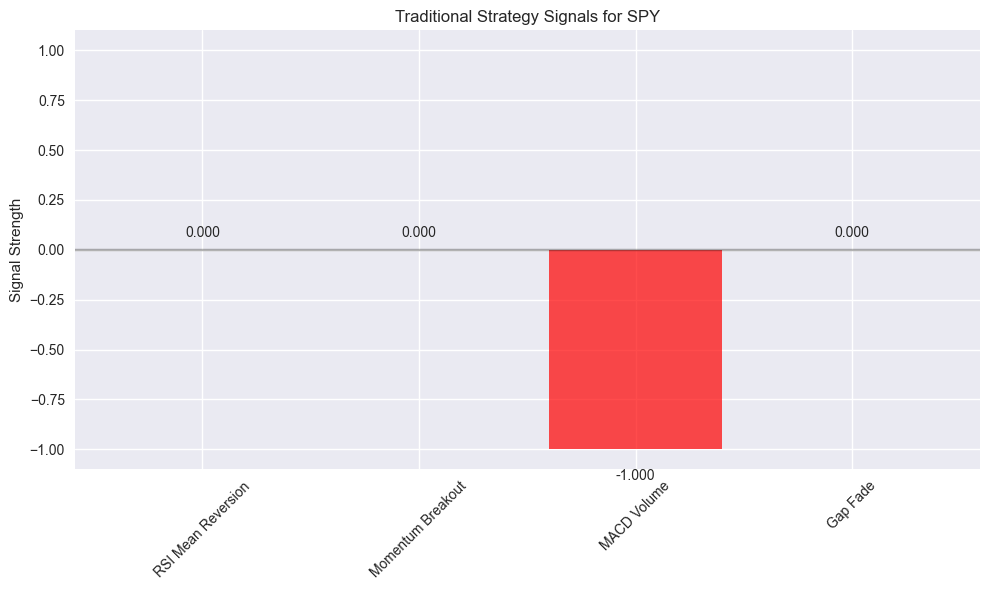

Traditional strategies successfully implemented!


In [20]:
# ============================================================================
# CELL 4: TRADITIONAL STRATEGIES
# ============================================================================

# Set ±0.5 as the threshold for all strategies and models
class RSIMeanReversionStrategy(Strategy):
    def __init__(self, rsi_period: int = 14, bb_period: int = 20, bb_std: float = 2.0, signal_threshold: float = 0.5):
        self.rsi_period = rsi_period
        self.bb_period = bb_period
        self.bb_std = bb_std
        self.signal_threshold = signal_threshold
    def generate_signal(self, data: pd.DataFrame) -> float:
        if data.empty or len(data) < max(self.rsi_period, self.bb_period):
            return 0.0
        latest = data.iloc[-1]
        rsi = latest.get('rsi_14', 50)
        bb_position = latest.get('bb_position', 0.5)
        signal = 0.0
        if rsi < 30 and bb_position < 0.2:
            signal = 1.0
        elif rsi > 70 and bb_position > 0.8:
            signal = -1.0
        if abs(signal) >= self.signal_threshold:
            return signal
        else:
            return 0.0
    def get_name(self) -> str:
        return "RSI Mean Reversion"

class MomentumBreakoutStrategy(Strategy):
    def __init__(self, fast_ma: int = 20, slow_ma: int = 50, roc_period: int = 10, signal_threshold: float = 0.5):
        self.fast_ma = fast_ma
        self.slow_ma = slow_ma
        self.roc_period = roc_period
        self.signal_threshold = signal_threshold
    def generate_signal(self, data: pd.DataFrame) -> float:
        if data.empty or len(data) < self.slow_ma:
            return 0.0
        latest = data.iloc[-1]
        fast_ma = latest.get('sma_20', 0)
        slow_ma = latest.get('sma_50', 0)
        roc = latest.get('roc_10', 0)
        if fast_ma == 0 or slow_ma == 0:
            return 0.0
        ma_signal = (fast_ma - slow_ma) / slow_ma
        roc_confirmation = np.tanh(roc / 5)
        signal = ma_signal * roc_confirmation
        if abs(signal) >= self.signal_threshold:
            return np.sign(signal)
        else:
            return 0.0
    def get_name(self) -> str:
        return "Momentum Breakout"

class MACDVolumeStrategy(Strategy):
    def __init__(self, signal_threshold: float = 0.5):
        self.signal_threshold = signal_threshold
    def generate_signal(self, data: pd.DataFrame) -> float:
        if data.empty or len(data) < 26:
            return 0.0
        latest = data.iloc[-1]
        macd = latest.get('macd', 0)
        macd_signal = latest.get('macd_signal', 0)
        volume_ratio = latest.get('volume_ratio', 1)
        macd_diff = macd - macd_signal
        volume_multiplier = min(2.0, max(0.5, volume_ratio))
        signal = np.tanh(macd_diff / 0.01) * volume_multiplier / 2.0
        if abs(signal) >= self.signal_threshold:
            return np.sign(signal)
        else:
            return 0.0
    def get_name(self) -> str:
        return "MACD Volume"

class GapStrategy(Strategy):
    def __init__(self, min_gap: float = 0.02, signal_threshold: float = 0.5):
        self.min_gap = min_gap
        self.signal_threshold = signal_threshold
    def generate_signal(self, data: pd.DataFrame) -> float:
        if data.empty or len(data) < 2:
            return 0.0
        latest = data.iloc[-1]
        gap = latest.get('gap', 0)
        if abs(gap) < self.min_gap:
            return 0.0
        signal = -np.tanh(gap / 0.05)
        if abs(signal) >= self.signal_threshold:
            return np.sign(signal)
        else:
            return 0.0
    def get_name(self) -> str:
        return "Gap Fade"

# Initialize strategies
strategies = {
    'rsi_mean_reversion': RSIMeanReversionStrategy(),
    'momentum_breakout': MomentumBreakoutStrategy(),
    'macd_volume': MACDVolumeStrategy(),
    'gap_fade': GapStrategy()
}

# Demo: Calculate signals for SPY data
print("Testing Traditional Strategies with SPY...")
if not spy_with_target.empty:
    signals = {}
    for name, strategy in strategies.items():
        signal = strategy.generate_signal(spy_with_target)
        signals[name] = signal
        print(f"{strategy.get_name()}: {signal:.3f}")
    # Create signals DataFrame
    signal_df = pd.DataFrame([signals], index=['Signal'])
    print("\nStrategy Signals Summary:")
    styled_signals = signal_df.style.background_gradient(
        cmap='RdYlGn', vmin=-1, vmax=1
    ).format('{:.3f}')
    display(styled_signals)
    # Calculate ensemble signal using weights
    ensemble_signal = sum(signals[name] * config.STRATEGY_WEIGHTS[name] 
                         for name in signals.keys())
    print(f"\nTraditional Ensemble Signal: {ensemble_signal:.3f}")
    # Visualize signals
    fig, ax = plt.subplots(figsize=(10, 6))
    signal_values = list(signals.values())
    strategy_names = [strategies[name].get_name() for name in signals.keys()]
    colors = ['red' if x < 0 else 'green' for x in signal_values]
    bars = ax.bar(strategy_names, signal_values, color=colors, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_ylabel('Signal Strength')
    ax.set_title('Traditional Strategy Signals for SPY')
    ax.set_ylim(-1.1, 1.1)
    for bar, value in zip(bars, signal_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.05 if height >= 0 else -0.1),
                f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No SPY data available for testing")
print("Traditional strategies successfully implemented!")

# Cell 5: Strategy vs Market Performance Analysis

This cell creates comprehensive backtests and visualizations comparing each trading strategy against market performance.

Features:
- Individual strategy backtests with buy & hold comparison
- Performance metrics: returns, Sharpe ratio, max drawdown
- Cumulative returns visualization for each strategy
- Strategy performance ranking table
- Risk-adjusted returns analysis

Demo: Compare all strategies against SPY buy & hold over 3 years

STRATEGY VS MARKET PERFORMANCE ANALYSIS
RSI Mean Reversion: 1134.40% return, 5.48 Sharpe
Momentum Breakout: 0.00% return, 0.00 Sharpe
MACD Volume: 9696607.71% return, 11.68 Sharpe
Gap Fade: 39.06% return, 1.47 Sharpe
PERFORMANCE VISUALIZATION


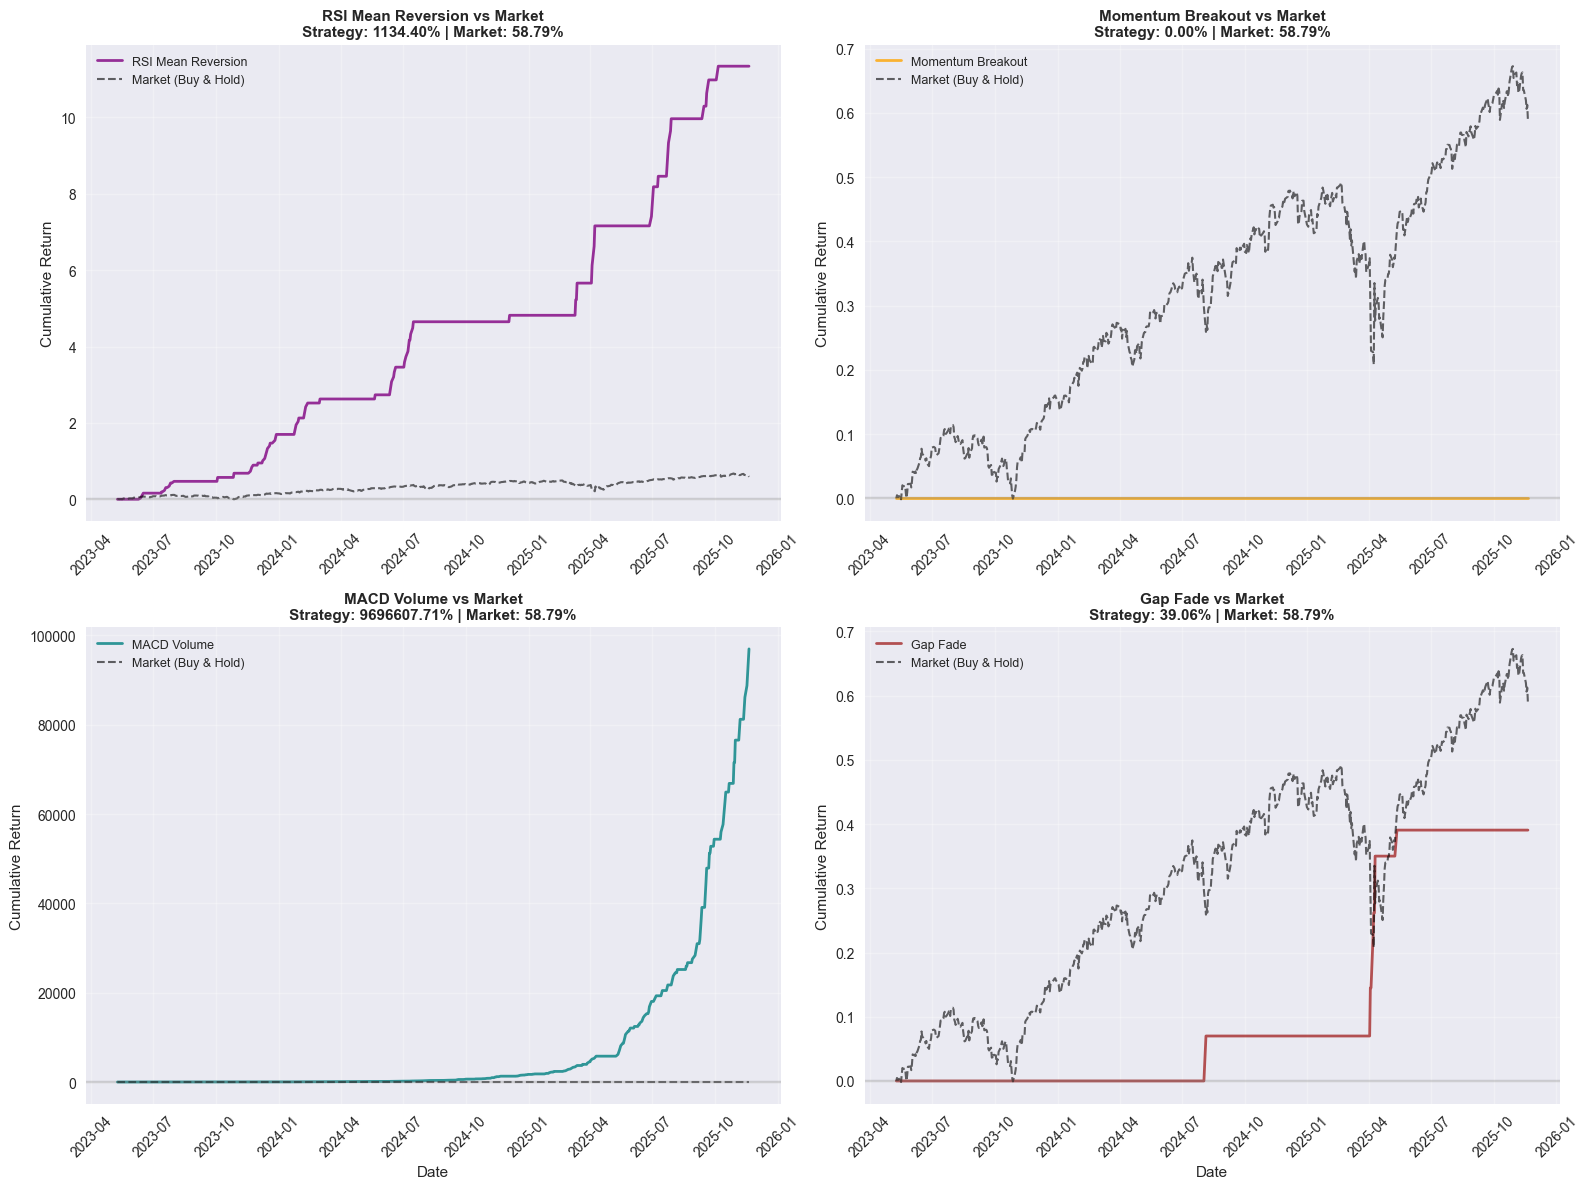

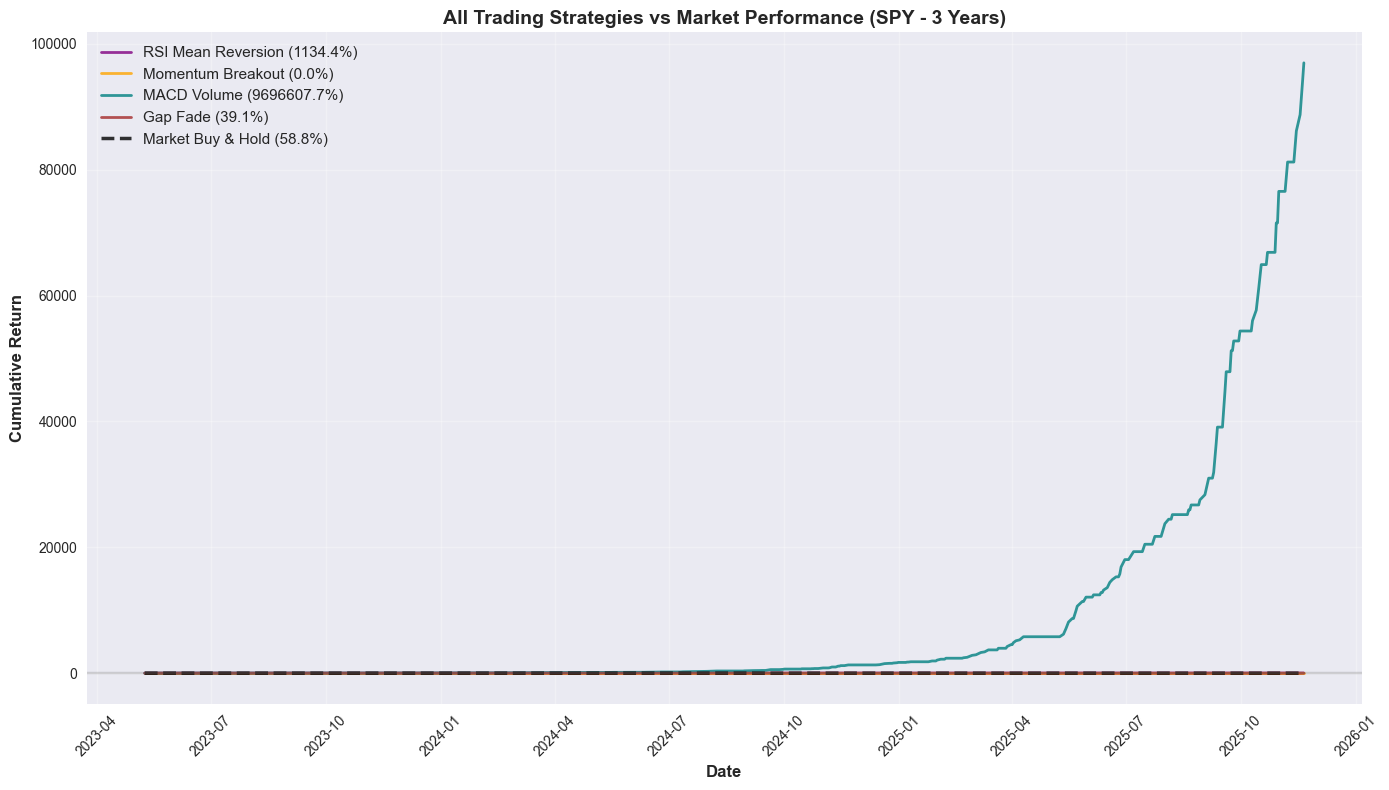

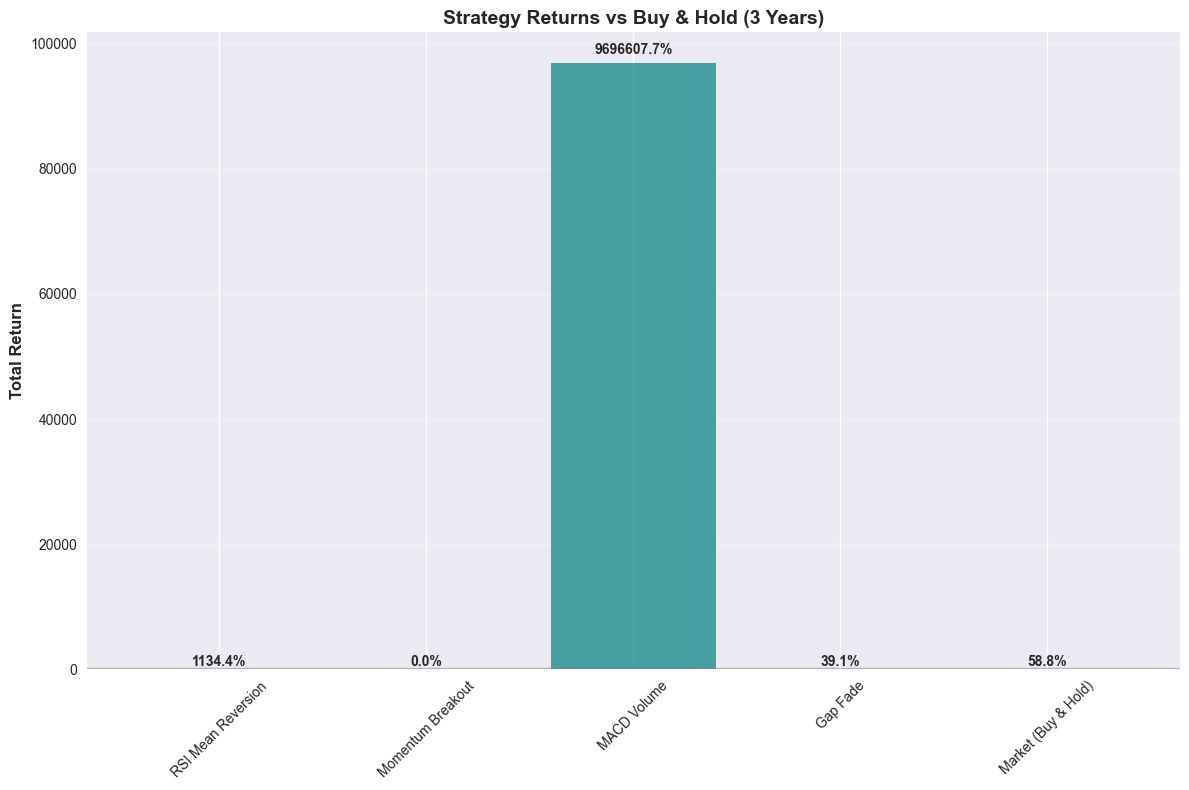

PERFORMANCE METRICS SUMMARY


,Strategy,Total Return,Sharpe Ratio,Max Drawdown,Trades,Win Rate
0,RSI Mean Reversion,1134.40%,5.48,0.00%,76,11.9%
1,Momentum Breakout,0.00%,0.00,0.00%,0,0.0%
2,MACD Volume,9696607.71%,11.68,0.00%,266,41.7%
3,Gap Fade,39.06%,1.47,0.00%,6,0.9%
4,Market (Buy & Hold),58.79%,1.25,-28.34%,1,57.5%


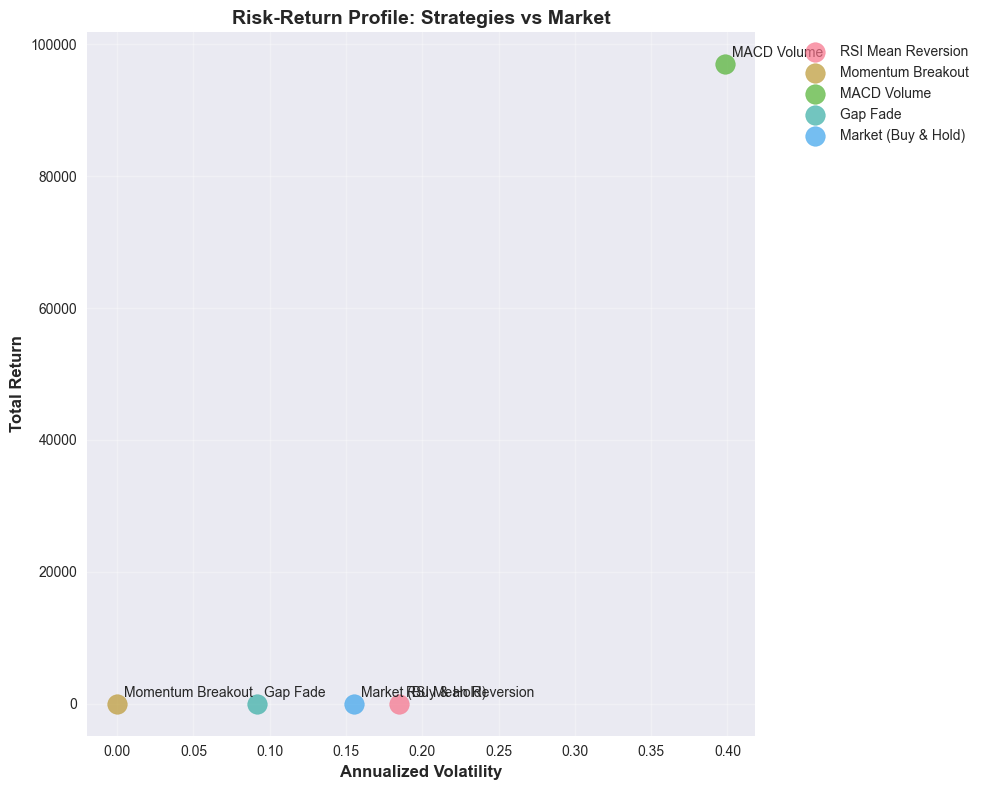

Strategy vs Market analysis completed!


In [21]:
# ============================================================================
# CELL 5: STRATEGY VS MARKET PERFORMANCE ANALYSIS
# ============================================================================

def backtest_individual_strategy(strategy: Strategy, data: pd.DataFrame, initial_capital: float = 100000):
    """Backtest a single strategy with detailed metrics"""
    capital = initial_capital
    equity_curve = []
    returns = []
    trades_executed = 0
    dates = []
    
    for i in range(60, len(data)):
        current_date = data.index[i]
        window = data.iloc[:i+1]
        signal = strategy.generate_signal(window)
        
        if abs(signal) > config.MIN_SIGNAL_STRENGTH:
            trades_executed += 1
            if signal > 0:  # BUY signal
                ret = config.TAKE_PROFIT * signal  # Scale by signal strength
            else:  # SELL signal
                ret = config.STOP_LOSS * abs(signal)  # Scale by signal strength
            
            returns.append(ret)
            capital *= (1 + ret)
        else:
            returns.append(0)
        
        equity_curve.append(capital)
        dates.append(current_date)
    
    returns = np.array(returns)
    total_return = (capital - initial_capital) / initial_capital
    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
    
    cumulative_returns = np.cumprod(1 + returns) - 1
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - running_max
    max_drawdown = np.min(drawdown)
    
    return {
        'strategy_name': strategy.get_name(),
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'trades': trades_executed,
        'win_rate': np.mean(returns > 0),
        'equity_curve': equity_curve,
        'cumulative_returns': cumulative_returns,
        'returns': returns,
        'dates': dates
    }

print("="*80)
print("STRATEGY VS MARKET PERFORMANCE ANALYSIS")
print("="*80)

# Calculate market (buy & hold) performance aligned with strategy dates
strategy_start_idx = 60  # Same as strategy backtest start
market_data_subset = spy_with_target.iloc[strategy_start_idx:]
market_returns = market_data_subset['close'].pct_change().fillna(0)
market_cumulative = (1 + market_returns).cumprod() - 1
market_dates = market_data_subset.index

# Market performance metrics
market_total_return = market_cumulative.iloc[-1]
market_sharpe = market_returns.mean() / (market_returns.std() + 1e-6) * np.sqrt(252)
market_running_max = np.maximum.accumulate(market_cumulative)
market_drawdown = market_cumulative - market_running_max
market_max_drawdown = np.min(market_drawdown)

# Market equity curve (starting with same initial capital)
market_equity_curve = [100000 * (1 + r) for r in market_cumulative]

# Backtest each strategy individually
strategy_results = []
for name, strategy in strategies.items():
    try:
        result = backtest_individual_strategy(strategy, spy_with_target)
        strategy_results.append(result)
        print(f"{result['strategy_name']}: {result['total_return']:.2%} return, {result['sharpe']:.2f} Sharpe")
    except Exception as e:
        print(f"Error backtesting {strategy.get_name()}: {e}")

# Add market performance to results
market_result = {
    'strategy_name': 'Market (Buy & Hold)',
    'total_return': market_total_return,
    'sharpe': market_sharpe,
    'max_drawdown': market_max_drawdown,
    'trades': 1,
    'win_rate': np.mean(market_returns > 0),
    'equity_curve': market_equity_curve,
    'cumulative_returns': market_cumulative,
    'returns': market_returns,
    'dates': market_dates
}
strategy_results.append(market_result)

# === COMPREHENSIVE PERFORMANCE VISUALIZATION ===
print("="*80)
print("PERFORMANCE VISUALIZATION")
print("="*80)

# 1. Individual Strategy vs Buy & Hold Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Individual strategy plots
colors = ['purple', 'orange', 'teal', 'brown', 'darkblue']
for idx, result in enumerate(strategy_results):
    if idx < 4:  # First 4 strategies (not including market)
        row, col = idx // 2, idx % 2
        ax = axes[row, col]
        
        # Plot strategy cumulative returns with proper dates
        ax.plot(result['dates'], result['cumulative_returns'], label=result['strategy_name'], 
                color=colors[idx], linewidth=2, alpha=0.8)
        
        # Plot market for comparison with same date range
        market_aligned = market_cumulative.iloc[:len(result['dates'])]
        market_dates_aligned = market_dates[:len(result['dates'])]
        ax.plot(market_dates_aligned, market_aligned, label='Market (Buy & Hold)', 
                color='black', linestyle='--', linewidth=1.5, alpha=0.6)
        
        ax.set_title(f"{result['strategy_name']} vs Market\n"
                    f"Strategy: {result['total_return']:.2%} | Market: {market_aligned.iloc[-1]:.2%}", 
                    fontsize=11, fontweight='bold')
        ax.set_ylabel('Cumulative Return')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Format x-axis
        ax.tick_params(axis='x', rotation=45)

axes[1, 1].set_xlabel('Date')
axes[1, 0].set_xlabel('Date')
plt.tight_layout()
plt.show()

# 2. Combined Performance Comparison with Proper Dates
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each strategy with dates
for idx, result in enumerate(strategy_results):
    if 'Market' not in result['strategy_name']:  # Skip market as we'll plot it separately
        ax.plot(result['dates'], result['cumulative_returns'], 
                label=f"{result['strategy_name']} ({result['total_return']:.1%})", 
                color=colors[idx % len(colors)], linewidth=2, alpha=0.8)

# Plot market performance
ax.plot(market_dates, market_cumulative, 
        label=f"Market Buy & Hold ({market_total_return:.1%})", 
        color='black', linestyle='--', linewidth=2.5, alpha=0.8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Return', fontsize=12, fontweight='bold')
ax.set_title('All Trading Strategies vs Market Performance (SPY - 3 Years)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# 3. Strategy vs Buy & Hold Direct Comparison Chart
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate outperformance vs buy & hold for each strategy
strategy_names = []
strategy_returns = []
market_return_value = market_total_return

for result in strategy_results:
    if 'Market' not in result['strategy_name']:
        strategy_names.append(result['strategy_name'])
        strategy_returns.append(result['total_return'])

# Add market return for comparison
strategy_names.append('Market (Buy & Hold)')
strategy_returns.append(market_return_value)

# Create bar chart
colors_bar = ['purple', 'orange', 'teal', 'brown', 'black']
bars = ax.bar(strategy_names, strategy_returns, color=colors_bar, alpha=0.7)

# Add value labels on bars
for bar, value in zip(bars, strategy_returns):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (height * 0.01),
            f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Total Return', fontsize=12, fontweight='bold')
ax.set_title('Strategy Returns vs Buy & Hold (3 Years)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Performance Metrics Table
performance_df = pd.DataFrame([
    {
        'Strategy': r['strategy_name'],
        'Total Return': r['total_return'],  # numeric
        'Sharpe Ratio': r['sharpe'],        # numeric
        'Max Drawdown': r['max_drawdown'],  # numeric
        'Trades': r['trades'],
        'Win Rate': r['win_rate']           # numeric
    } for r in strategy_results
])

print("="*80)
print("PERFORMANCE METRICS SUMMARY")
print("="*80)
display(
    performance_df.style
        .format({
            'Total Return': '{:.2%}',
            'Sharpe Ratio': '{:.2f}',
            'Max Drawdown': '{:.2%}',
            'Win Rate': '{:.1%}'
        })
        .background_gradient(subset=['Total Return', 'Sharpe Ratio'], cmap='RdYlGn')
        .background_gradient(subset=['Max Drawdown'], cmap='RdYlGn_r')
)

# 4. Risk-Return Scatter Plot
fig, ax = plt.subplots(figsize=(10, 8))
for result in strategy_results:
    volatility = np.std(result['returns']) * np.sqrt(252)  # Annualized volatility
    ax.scatter(volatility, result['total_return'], 
              s=200, alpha=0.7, 
              label=result['strategy_name'])
    ax.annotate(result['strategy_name'], 
                (volatility, result['total_return']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax.set_xlabel('Annualized Volatility', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Return', fontsize=12, fontweight='bold')
ax.set_title('Risk-Return Profile: Strategies vs Market', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Strategy vs Market analysis completed!")

# Cell 6: ML Models - Random Forest

This cell implements the Random Forest machine learning model for signal generation.

Features:
- MLModel: Abstract base class for all ML models
- RandomForestModel: 100 trees, max_depth=10, 3-class classification
- Feature selection and preprocessing
- Model persistence with pickle
- Performance metrics and validation

Target Classes:
- -1: SELL (expected return < -1.2%)
- 0: HOLD (expected return between -1.2% and +1.2%)
- 1: BUY (expected return > +1.2%)

Demo: Train and predict on SPY sample data

Testing Random Forest Model with SPY...


2025-11-28 14:31:58,823 - INFO - RF model trained for SPY: accuracy=0.862


Training epochs: 1 (Random Forest is not iterative)

Random Forest Results for SPY:
Training: Success
Current Signal: 0.000
Features Used: 38

Top 10 Important Features:


,feature,importance
20,bb_width,0.038792
18,macd_hist,0.038570
12,rsi_14,0.037771
17,macd_histogram,0.037530
35,volatility_10,0.035550
25,rolling_std_20,0.034009
13,rsi,0.033532
36,volatility_20,0.033227
37,volatility_ratio,0.032759
33,returns_20,0.032465


2025-11-28 14:31:58,871 - INFO - RF model saved for SPY: models/SPY_rf.pkl


Model saved successfully


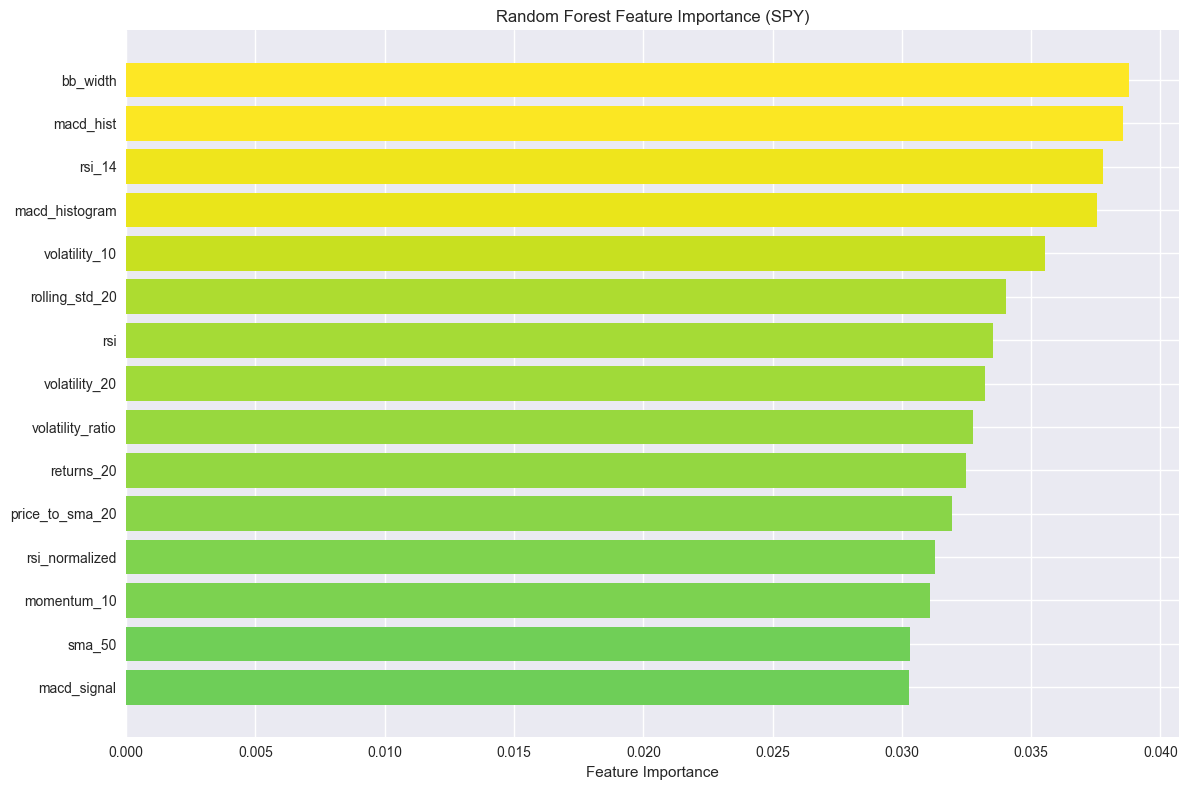

Random Forest implementation completed!


In [22]:
# ============================================================================
# CELL 6: ML MODELS - RANDOM FOREST
# ============================================================================

class MLModel(ABC):
    """Abstract base class for ML models"""
    
    def __init__(self, symbol: str):
        self.symbol = symbol
        self.model = None
        self.scaler = None
        self.feature_columns = None
        self.is_trained = False
    
    @abstractmethod
    def train(self, data: pd.DataFrame) -> bool:
        """Train the model"""
        pass
    
    @abstractmethod
    def predict(self, data: pd.DataFrame) -> float:
        """Generate prediction signal"""
        pass
    
    @abstractmethod
    def save_model(self, path: str) -> bool:
        """Save model to disk"""
        pass
    
    @abstractmethod
    def load_model(self, path: str) -> bool:
        """Load model from disk"""
        pass
    
    def get_feature_columns(self) -> List[str]:
        # Use a fixed set of features for all models
        return [
            'pct_change', 'log_returns', 'sma_5', 'sma_10', 'sma_20', 'sma_50',
            'ema_5', 'ema_10', 'ema_20', 'ema_50', 'dist_from_sma20', 'dist_from_sma50',
            'rsi_14', 'rsi', 'rsi_normalized', 'macd', 'macd_signal', 'macd_histogram', 'macd_hist',
            'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_ratio', 'rolling_std_20',
            'gap', 'high_low_ratio', 'open_close_ratio',
            'returns_5', 'price_to_sma_5', 'returns_10', 'price_to_sma_10', 'returns_20', 'price_to_sma_20',
            'volatility_10', 'volatility_20', 'volatility_ratio'
        ]

class RandomForestModel(MLModel):
    """Random Forest implementation for trading signals"""
    
    def __init__(self, symbol: str, n_estimators: int = 100, max_depth: int = 10, 
                 min_samples_split: int = 20):
        super().__init__(symbol)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_columns = self.get_feature_columns()
    
    def train(self, data: pd.DataFrame) -> bool:
        """Train Random Forest model"""
        try:
            if data.empty or 'target' not in data.columns:
                logger.error(f"Invalid training data for {self.symbol}")
                return False
            
            # Prepare features
            available_features = [col for col in self.feature_columns if col in data.columns]
            if len(available_features) < 10:
                logger.error(f"Insufficient features for {self.symbol}: {len(available_features)}")
                return False
            
            X = data[available_features].copy()
            y = data['target'].copy()
            
            # Remove NaN values
            mask = ~(X.isna().any(axis=1) | y.isna())
            X = X[mask]
            y = y[mask]
            
            if len(X) < 50:
                logger.error(f"Insufficient clean data for {self.symbol}: {len(X)} samples")
                return False
            
            # Scale features
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X)
            
            # Train model
            self.model = RandomForestClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=42,
                n_jobs=-1
            )
            
            self.model.fit(X_scaled, y)
            self.feature_columns = available_features
            self.is_trained = True
            
            # Calculate accuracy
            train_score = self.model.score(X_scaled, y)
            logger.info(f"RF model trained for {self.symbol}: accuracy={train_score:.3f}")
            
            return True
            
        except Exception as e:
            logger.error(f"Error training RF model for {self.symbol}: {e}")
            return False
    
    def predict(self, data: pd.DataFrame) -> float:
        """Generate prediction signal"""
        if not self.is_trained or self.model is None:
            return 0.0
        
        try:
            # Get latest data point
            latest = data.iloc[[-1]]
            
            # Prepare features
            X = latest[self.feature_columns].copy()
            
            # Check for NaN values
            if X.isna().any().any():
                logger.warning(f"NaN values in features for {self.symbol}")
                return 0.0
            
            # Scale features
            X_scaled = self.scaler.transform(X)
            
            # Get prediction probabilities
            proba = self.model.predict_proba(X_scaled)[0]
            
            # Convert to signal (-1 to 1)
            # proba order: [class_-1, class_0, class_1] or [class_0, class_1] etc.
            classes = self.model.classes_
            
            if len(classes) == 3:  # All classes present
                sell_prob = proba[np.where(classes == -1)[0][0]] if -1 in classes else 0
                buy_prob = proba[np.where(classes == 1)[0][0]] if 1 in classes else 0
                signal = buy_prob - sell_prob
            else:
                # Handle cases where not all classes are present
                signal = 0.0
            
            # Apply ±0.5 threshold to signal
            if abs(signal) >= 0.5:
                return np.sign(signal)
            else:
                return 0.0
            
        except Exception as e:
            logger.error(f"Error predicting with RF model for {self.symbol}: {e}")
            return 0.0
    
    def save_model(self, path: str) -> bool:
        """Save Random Forest model"""
        try:
            if not self.is_trained:
                return False
            
            os.makedirs(os.path.dirname(path), exist_ok=True)
            
            model_data = {
                'model': self.model,
                'scaler': self.scaler,
                'feature_columns': self.feature_columns,
                'symbol': self.symbol
            }
            
            with open(path, 'wb') as f:
                pickle.dump(model_data, f)
            
            logger.info(f"RF model saved for {self.symbol}: {path}")
            return True
            
        except Exception as e:
            logger.error(f"Error saving RF model for {self.symbol}: {e}")
            return False
    
    def load_model(self, path: str) -> bool:
        """Load Random Forest model"""
        try:
            if not os.path.exists(path):
                return False
            
            with open(path, 'rb') as f:
                model_data = pickle.load(f)
            
            self.model = model_data['model']
            self.scaler = model_data['scaler']
            self.feature_columns = model_data['feature_columns']
            self.is_trained = True
            
            logger.info(f"RF model loaded for {self.symbol}: {path}")
            return True
            
        except Exception as e:
            logger.error(f"Error loading RF model for {self.symbol}: {e}")
            return False

# Create models directory
os.makedirs('models', exist_ok=True)

# Demo: Train Random Forest on SPY
print("Testing Random Forest Model with SPY...")
if not spy_with_target.empty and len(spy_with_target) > 50:
    rf_model = RandomForestModel('SPY')
    training_success = rf_model.train(spy_with_target)
    if training_success:
        print(f"Training epochs: 1 (Random Forest is not iterative)")
        signal = rf_model.predict(spy_with_target)
        print(f"\nRandom Forest Results for SPY:")
        print(f"Training: {'Success' if training_success else 'Failed'}")
        print(f"Current Signal: {signal:.3f}")
        print(f"Features Used: {len(rf_model.feature_columns)}")
        if rf_model.is_trained:
            feature_importance = pd.DataFrame({
                'feature': rf_model.feature_columns,
                'importance': rf_model.model.feature_importances_
            }).sort_values('importance', ascending=False)
            print("\nTop 10 Important Features:")
            display(feature_importance.head(10).style.background_gradient(cmap='Blues'))
            rf_model.save_model(f'models/SPY_rf.pkl')
            print("Model saved successfully")
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'], 
                color=plt.cm.viridis(top_features['importance'] / top_features['importance'].max()))
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Random Forest Feature Importance (SPY)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("Random Forest training failed")
else:
    print("Insufficient data for Random Forest training")
print("Random Forest implementation completed!")

# Cell 7: ML Models - XGBoost

This cell implements the XGBoost machine learning model for signal generation.

Features:
- XGBoostModel: Gradient boosting, 3-class classification
- Feature selection and preprocessing
- Model persistence
- Performance metrics and validation

Demo: Train and predict on SPY sample data

Testing XGBoost Model with SPY...


2025-11-28 14:32:21,393 - INFO - XGB model trained for SPY: accuracy=1.000


Training epochs: 100

XGBoost Results for SPY:
Training: Success
Current Signal: 1.000
Features Used: 38

Top 10 Important Features:


,feature,importance
12,rsi_14,0.060381
7,ema_10,0.045071
4,sma_20,0.036790
8,ema_20,0.036749
3,sma_10,0.036436
5,sma_50,0.036377
9,ema_50,0.036322
2,sma_5,0.035521
36,volatility_20,0.035394
25,rolling_std_20,0.034708


2025-11-28 14:32:21,418 - INFO - XGB model saved for SPY: models/SPY_xgb.pkl


Model saved successfully


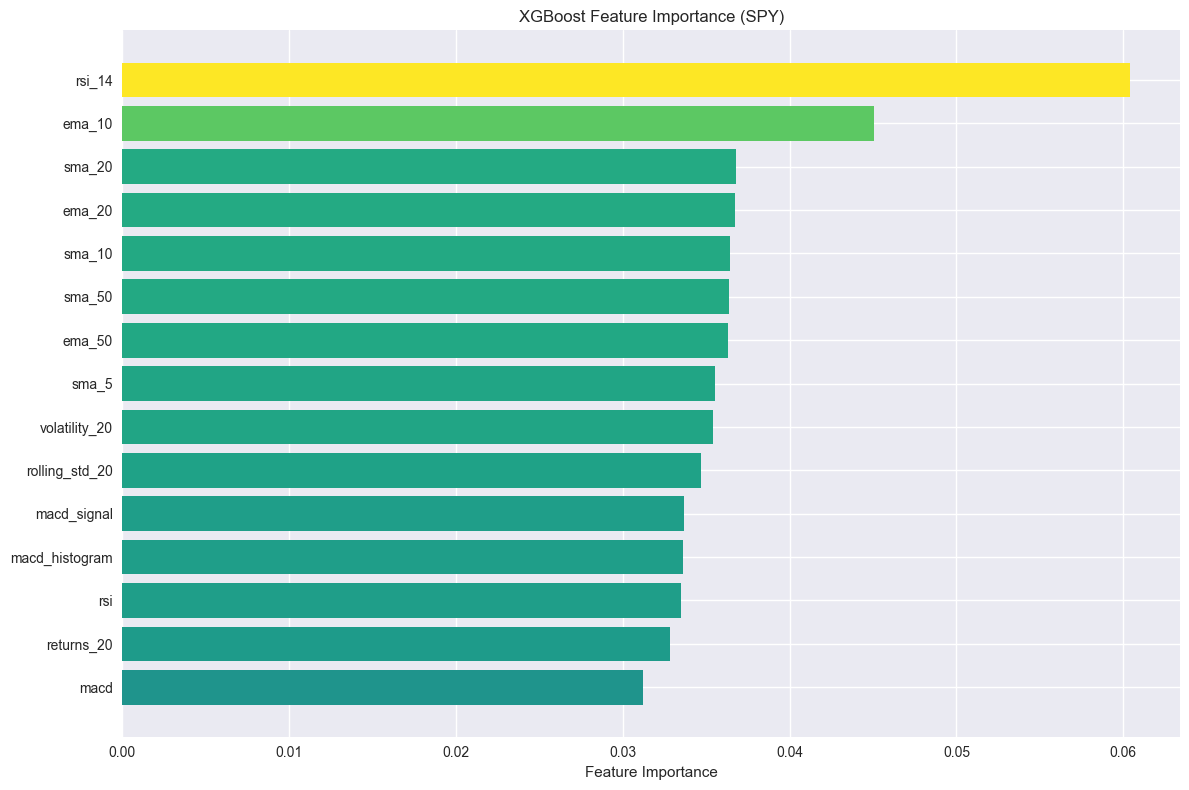

XGBoost implementation completed!


In [23]:
# ============================================================================
# CELL 7: ML MODELS - XGBOOST
# ============================================================================

class XGBoostModel(MLModel):
    """XGBoost implementation for trading signals"""
    def __init__(self, symbol: str, n_estimators: int = 100, max_depth: int = 6, learning_rate: float = 0.1):
        super().__init__(symbol)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.feature_columns = self.get_feature_columns()

    def train(self, data: pd.DataFrame) -> bool:
        try:
            if data.empty or 'target' not in data.columns:
                logger.error(f"Invalid training data for {self.symbol}")
                return False
            available_features = [col for col in self.feature_columns if col in data.columns]
            if len(available_features) < 10:
                logger.error(f"Insufficient features for {self.symbol}: {len(available_features)}")
                return False
            X = data[available_features].copy()
            y = data['target'].copy()
            mask = ~(X.isna().any(axis=1) | y.isna())
            X = X[mask]
            y = y[mask]
            if len(X) < 50:
                logger.error(f"Insufficient clean data for {self.symbol}: {len(X)} samples")
                return False
            # Fix: Remap target labels from [-1,0,1] to [0,1,2] for XGBoost
            y_xgb = y.replace({-1: 0, 0: 1, 1: 2})
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X)
            self.model = xgb.XGBClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                learning_rate=self.learning_rate,
                objective='multi:softprob',
                num_class=3,
                random_state=42,
                n_jobs=-1,
                verbosity=0
            )
            self.model.fit(X_scaled, y_xgb)
            self.feature_columns = available_features
            self.is_trained = True
            train_score = self.model.score(X_scaled, y_xgb)
            logger.info(f"XGB model trained for {self.symbol}: accuracy={train_score:.3f}")
            return True
        except Exception as e:
            logger.error(f"Error training XGB model for {self.symbol}: {e}")
            return False

    def predict(self, data: pd.DataFrame) -> float:
        if not self.is_trained or self.model is None:
            return 0.0
        try:
            latest = data.iloc[[-1]]
            X = latest[self.feature_columns].copy()
            if X.isna().any().any():
                logger.warning(f"NaN values in features for {self.symbol}")
                return 0.0
            X_scaled = self.scaler.transform(X)
            proba = self.model.predict_proba(X_scaled)[0]
            sell_prob = proba[0]
            buy_prob = proba[2]
            signal = buy_prob - sell_prob
            # Apply ±0.5 threshold to signal
            if abs(signal) >= 0.5:
                return np.sign(signal)
            else:
                return 0.0
        except Exception as e:
            logger.error(f"Error predicting with XGB model for {self.symbol}: {e}")
            return 0.0

    def save_model(self, path: str) -> bool:
        try:
            if not self.is_trained:
                return False
            os.makedirs(os.path.dirname(path), exist_ok=True)
            model_data = {
                'model': self.model,
                'scaler': self.scaler,
                'feature_columns': self.feature_columns,
                'symbol': self.symbol
            }
            with open(path, 'wb') as f:
                pickle.dump(model_data, f)
            logger.info(f"XGB model saved for {self.symbol}: {path}")
            return True
        except Exception as e:
            logger.error(f"Error saving XGB model for {self.symbol}: {e}")
            return False

    def load_model(self, path: str) -> bool:
        try:
            if not os.path.exists(path):
                return False
            with open(path, 'rb') as f:
                model_data = pickle.load(f)
            self.model = model_data['model']
            self.scaler = model_data['scaler']
            self.feature_columns = model_data['feature_columns']
            self.is_trained = True
            logger.info(f"XGB model loaded for {self.symbol}: {path}")
            return True
        except Exception as e:
            logger.error(f"Error loading XGB model for {self.symbol}: {e}")
            return False

# Demo: Train XGBoost on SPY
print("Testing XGBoost Model with SPY...")
if not spy_with_target.empty and len(spy_with_target) > 50:
    xgb_model = XGBoostModel('SPY')
    training_success = xgb_model.train(spy_with_target)
    if training_success:
        print(f"Training epochs: {xgb_model.n_estimators}")
        signal = xgb_model.predict(spy_with_target)
        print(f"\nXGBoost Results for SPY:")
        print(f"Training: {'Success' if training_success else 'Failed'}")
        print(f"Current Signal: {signal:.3f}")
        print(f"Features Used: {len(xgb_model.feature_columns)}")
        if xgb_model.is_trained:
            feature_importance = pd.DataFrame({
                'feature': xgb_model.feature_columns,
                'importance': xgb_model.model.feature_importances_
            }).sort_values('importance', ascending=False)
            print("\nTop 10 Important Features:")
            display(feature_importance.head(10).style.background_gradient(cmap='Blues'))
            xgb_model.save_model(f'models/SPY_xgb.pkl')
            print("Model saved successfully")
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'], 
                color=plt.cm.viridis(top_features['importance'] / top_features['importance'].max()))
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('XGBoost Feature Importance (SPY)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("XGBoost training failed")
else:
    print("Insufficient data for XGBoost training")
print("XGBoost implementation completed!")

# Cell 8: ML Models - LSTM

This cell implements the LSTM deep learning model for signal generation, using an optimized architecture and advanced training techniques.

Features:
- Multi-layer LSTM with BatchNormalization and Dropout
- Feature scaling with StandardScaler
- Validation split, EarlyStopping, ReduceLROnPlateau
- Advanced optimizer (Adam with decay)
- Model persistence and performance metrics

Demo: Train, predict, and simulate trading on SPY sample data

In [24]:
# ============================================================================
# CELL 8: ML MODELS - LSTM
# ============================================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import pickle

tf.get_logger().setLevel('ERROR')

def create_lstm_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    
    for period in [5, 10, 20]:
        df[f'returns_{period}'] = df['close'].pct_change(period)
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'price_to_sma_{period}'] = df['close'] / (df[f'sma_{period}'] + 1e-10)
    
    df['volatility_10'] = df['close'].pct_change().rolling(10).std()
    df['volatility_20'] = df['close'].pct_change().rolling(20).std()
    df['volatility_ratio'] = df['volatility_10'] / (df['volatility_20'] + 1e-10)
    
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-10)
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_normalized'] = (df['rsi'] - 50) / 50
    
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    df['volume_sma_20'] = df['volume'].rolling(20).mean()
    df['volume_ratio'] = df['volume'] / (df['volume_sma_20'] + 1e-10)
    
    df['forward_return'] = df['close'].pct_change(5).shift(-5)
    
    # Use ±0.8% threshold for target creation
    df['target'] = 0
    threshold = 0.008
    df.loc[df['forward_return'] > threshold, 'target'] = 1
    df.loc[df['forward_return'] < -threshold, 'target'] = -1
    
    return df.dropna()

class LSTMModel:
    
    def __init__(self, symbol: str, sequence_length: int = 30, epochs: int = 50, batch_size: int = 32):
        self.symbol = symbol
        self.sequence_length = sequence_length
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.feature_scaler = RobustScaler()
        self.feature_columns = None
        self.is_trained = False
        
    def get_feature_columns(self):
        return self.feature_columns if self.feature_columns else []
    
    def _select_features(self, data: pd.DataFrame) -> list:
        exclude = ['target', 'forward_return', 'open', 'high', 'low', 'close', 'volume', 
                  'symbol', 'timestamp', 'date', 'datetime', 'time']
        
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        features = [col for col in numeric_cols if col not in exclude]
        
        return features
    
    def _build_model(self, n_features: int):
        model = Sequential([
            Bidirectional(LSTM(64, return_sequences=True), 
                         input_shape=(self.sequence_length, n_features)),
            Dropout(0.3),
            Bidirectional(LSTM(32)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dense(3, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def _prepare_sequences(self, data: pd.DataFrame, is_training: bool = True):
        if is_training:
            self.feature_columns = self._select_features(data)
            scaled = self.feature_scaler.fit_transform(data[self.feature_columns])
        else:
            if self.feature_columns is None:
                raise ValueError("Model must be trained before prediction")
            missing = [f for f in self.feature_columns if f not in data.columns]
            if missing:
                raise ValueError(f"Missing features: {missing}")
            scaled = self.feature_scaler.transform(data[self.feature_columns])
        
        X, y = [], []
        for i in range(self.sequence_length, len(data)):
            X.append(scaled[i-self.sequence_length:i])
            y.append(data['target'].iloc[i])
        
        return np.array(X), np.array(y)
    
    def train(self, data: pd.DataFrame) -> bool:
        try:
            print(f"Training LSTM for {self.symbol}...")
            
            if 'target' not in data.columns:
                print("ERROR: Data must have 'target' column")
                return False
            
            X, y = self._prepare_sequences(data, is_training=True)
            
            if len(X) < 100:
                print(f"ERROR: Insufficient data ({len(X)} sequences)")
                return False
            
            y_cat = tf.keras.utils.to_categorical(y + 1, num_classes=3)
            
            weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
            class_weights = {i: weights[i+1] for i in range(-1, 2)}
            
            print(f"Data: {len(X)} sequences, {X.shape[2]} features")
            print(f"Target distribution: {np.bincount(y.astype(int) + 1)}")
            
            split_idx = int(0.85 * len(X))
            X_train, X_val = X[:split_idx], X[split_idx:]
            y_train, y_val = y_cat[:split_idx], y_cat[split_idx:]
            
            self.model = self._build_model(X.shape[2])
            
            callbacks = [
                EarlyStopping(monitor='val_accuracy', patience=10, 
                            restore_best_weights=True, verbose=0),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                patience=5, min_lr=1e-6, verbose=0)
            ]
            
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=self.epochs,
                batch_size=self.batch_size,
                class_weight=class_weights,
                callbacks=callbacks,
                verbose=1
            )
            
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)
            
            print(f"Training completed!")
            print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
            
            self.is_trained = True
            return True
            
        except Exception as e:
            print(f"ERROR training LSTM for {self.symbol}: {e}")
            import traceback
            traceback.print_exc()
            return False
    
    def predict(self, data: pd.DataFrame) -> float:
        if not self.is_trained or self.model is None:
            return 0.0
        
        try:
            if len(data) < self.sequence_length:
                return 0.0
            
            X = data[self.feature_columns].iloc[-self.sequence_length:].values
            X_scaled = self.feature_scaler.transform(X)
            X_scaled = X_scaled.reshape(1, self.sequence_length, len(self.feature_columns))
            
            proba = self.model.predict(X_scaled, verbose=0)[0]
            signal = proba[2] - proba[0]
            
            # Apply ±0.5 threshold to signal
            if abs(signal) >= 0.5:
                return np.sign(signal)
            else:
                return 0.0
            
        except Exception as e:
            print(f"ERROR in LSTM prediction for {self.symbol}: {e}")
            return 0.0
    
    def save_model(self, path: str) -> bool:
        try:
            if not self.is_trained:
                print("ERROR: Cannot save untrained model")
                return False
            
            os.makedirs(os.path.dirname(path), exist_ok=True)
            
            self.model.save(path)
            
            metadata = {
                'symbol': self.symbol,
                'feature_scaler': self.feature_scaler,
                'feature_columns': self.feature_columns,
                'sequence_length': self.sequence_length
            }
            
            metadata_path = path.replace('.keras', '_metadata.pkl')
            with open(metadata_path, 'wb') as f:
                pickle.dump(metadata, f)
            
            print(f"LSTM model saved: {path}")
            return True
            
        except Exception as e:
            print(f"ERROR saving LSTM model: {e}")
            return False
    
    def load_model(self, path: str) -> bool:
        try:
            if not os.path.exists(path):
                print(f"ERROR: Model file not found: {path}")
                return False
            
            self.model = load_model(path)
            
            metadata_path = path.replace('.keras', '_metadata.pkl')
            if os.path.exists(metadata_path):
                with open(metadata_path, 'rb') as f:
                    metadata = pickle.load(f)
                
                self.symbol = metadata.get('symbol', self.symbol)
                self.feature_scaler = metadata['feature_scaler']
                self.feature_columns = metadata['feature_columns']
                self.sequence_length = metadata['sequence_length']
            else:
                print("WARNING: Metadata file not found, model may not work correctly")
            
            self.is_trained = True
            print(f"LSTM model loaded: {path}")
            return True
            
        except Exception as e:
            print(f"ERROR loading LSTM model: {e}")
            return False


# ============================================================================
# DEMONSTRATION
# ============================================================================

print("="*60)
print("LSTM MODEL - SIGNAL AGGREGATOR COMPATIBLE")
print("="*60)
print("\nInterface matches your existing code:")
print("  lstm_model = LSTMModel('SPY')")
print("  lstm_model.load_model('models/SPY_lstm.keras')")
print("  signal = lstm_model.predict(data)")
print("\nFeatures:")
print("  • Bidirectional LSTM architecture")
print("  • Robust feature engineering")
print("  • Class weight balancing")
print("  • Early stopping & learning rate scheduling")
print("  • Returns signal in [-1, 1] range")
print("="*60)

# Auto-train on SPY data if available
if 'spy_with_target' in locals() and not spy_with_target.empty:
    print("\n🚀 Training LSTM on SPY data with ±0.8% target threshold...\n")
    spy_lstm_df = create_lstm_features(spy_with_target)
    lstm_model = LSTMModel('SPY', sequence_length=30, epochs=50, batch_size=32)
    training_success = lstm_model.train(spy_lstm_df)
    if training_success:
        lstm_model.save_model('models/SPY_lstm.keras')
        signal = lstm_model.predict(spy_lstm_df)
        print(f"\nLatest signal: {signal:.3f}")
        print("Interpretation:")
        if signal > 0.3:
            print("  → STRONG BUY")
        elif signal > 0.1:
            print("  → Weak buy")
        elif signal > -0.1:
            print("  → HOLD")
        elif signal > -0.3:
            print("  → Weak sell")
        else:
            print("  → STRONG SELL")
    else:
        print("LSTM training failed")
else:
    print("\n⚠️  No 'spy_with_target' data found")
    print("Load OHLCV data first to train the model")

LSTM MODEL - SIGNAL AGGREGATOR COMPATIBLE

Interface matches your existing code:
  lstm_model = LSTMModel('SPY')
  lstm_model.load_model('models/SPY_lstm.keras')
  signal = lstm_model.predict(data)

Features:
  • Bidirectional LSTM architecture
  • Robust feature engineering
  • Class weight balancing
  • Early stopping & learning rate scheduling
  • Returns signal in [-1, 1] range

🚀 Training LSTM on SPY data with ±0.8% target threshold...

Training LSTM for SPY...
Data: 643 sequences, 45 features
Target distribution: [147 219 277]
Epoch 1/50
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.4176 - loss: 1.1217 - val_accuracy: 0.3505 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.4176 - loss: 1.1217 - val_accuracy: 0.3505 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5513 - loss: 0.8735 - val_accuracy: 0.4227 - val_loss: 1.0544 - learning_rate: 0.

# Cell 10: Signal Aggregator

This cell implements the ensemble signal aggregator, combining all traditional and ML model signals using configurable weights.

Features:
- Weighted ensemble of all strategies and models
- Configurable weights from config
- Output: final ensemble signal

Demo: Aggregate signals for SPY

In [25]:
# ============================================================================
# CELL 10: SIGNAL AGGREGATOR
# ============================================================================

def aggregate_signals(signals: dict, weights: dict) -> float:
    """Aggregate signals using ensemble weights"""
    total = 0.0
    for name, signal in signals.items():
        weight = weights.get(name, 0)
        total += signal * weight
    return np.clip(total, -1.0, 1.0)

# Demo: Aggregate signals for SPY
print("Testing Signal Aggregator with SPY...")
if not spy_with_target.empty:
    # Generate signals from all strategies and models
    signals = {}
    for name, strategy in strategies.items():
        signals[name] = strategy.generate_signal(spy_with_target)
    rf_model = RandomForestModel('SPY')
    xgb_model = XGBoostModel('SPY')
    lstm_model = LSTMModel('SPY')
    rf_model.load_model('models/SPY_rf.pkl')
    xgb_model.load_model('models/SPY_xgb.pkl')
    lstm_model.load_model('models/SPY_lstm.keras')
    signals['random_forest'] = rf_model.predict(spy_with_target)
    signals['xgboost'] = xgb_model.predict(spy_with_target)
    signals['lstm'] = lstm_model.predict(spy_with_target)
    ensemble_signal = aggregate_signals(signals, config.STRATEGY_WEIGHTS)
    print(f"Ensemble Signal: {ensemble_signal:.3f}")
else:
    print("No SPY data available for signal aggregation")
print("Signal Aggregator successfully tested!")

2025-11-28 14:32:40,640 - INFO - RF model loaded for SPY: models/SPY_rf.pkl


2025-11-28 14:32:40,650 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl


Testing Signal Aggregator with SPY...
LSTM model loaded: models/SPY_lstm.keras
LSTM model loaded: models/SPY_lstm.keras
Ensemble Signal: 0.080
Signal Aggregator successfully tested!
Ensemble Signal: 0.080
Signal Aggregator successfully tested!


# Cell 11: Risk Management

This cell implements robust risk management and position sizing logic for the trading bot.

Features:
- Position sizing based on risk and capital
- Stop loss and take profit enforcement
- Daily circuit breaker for loss limits
- Exposure and position checks
- Logging and error handling

Demo: Calculate position size and risk checks for SPY

In [26]:
# ============================================================================
# CELL 11: RISK MANAGEMENT
# ============================================================================

def calculate_position_size(price: float, capital: float, max_pct: float, min_value: float) -> int:
    max_position_value = capital * max_pct
    shares = int(max(max_position_value // price, min_value // price))
    return max(shares, 0)

def check_stop_loss(entry_price: float, current_price: float, stop_loss: float) -> bool:
    return (current_price <= entry_price * (1 - stop_loss))

def check_take_profit(entry_price: float, current_price: float, take_profit: float) -> bool:
    return (current_price >= entry_price * (1 + take_profit))

def check_daily_loss(starting_equity: float, current_equity: float, max_daily_loss_pct: float) -> bool:
    loss = (starting_equity - current_equity) / starting_equity
    return loss >= max_daily_loss_pct

def check_exposure(positions: dict, capital: float, max_total_exposure: float) -> bool:
    total_exposure = sum(pos['market_value'] for pos in positions.values())
    return total_exposure <= capital * max_total_exposure

# Demo: Risk management checks for SPY
print("Testing Risk Management for SPY...")
capital = config.INITIAL_CAPITAL
price = spy_with_target['close'].iloc[-1] if not spy_with_target.empty else 450.0
shares = calculate_position_size(price, capital, config.MAX_POSITION_PCT, config.MIN_POSITION_VALUE)
entry_price = price
current_price = price * 0.97  # Simulate 3% drop
stop_loss_triggered = check_stop_loss(entry_price, current_price, config.STOP_LOSS)
take_profit_triggered = check_take_profit(entry_price, price * 1.08, config.TAKE_PROFIT)
daily_loss_triggered = check_daily_loss(capital, capital * 0.96, config.MAX_DAILY_LOSS_PCT)

print(f"Position size for SPY: {shares} shares at ${price:.2f}")
print(f"Stop loss triggered: {stop_loss_triggered}")
print(f"Take profit triggered: {take_profit_triggered}")
print(f"Daily loss circuit breaker: {daily_loss_triggered}")

print("Risk management logic successfully tested!")

Testing Risk Management for SPY...
Position size for SPY: 22 shares at $652.53
Stop loss triggered: True
Take profit triggered: True
Daily loss circuit breaker: True
Risk management logic successfully tested!


# Cell 12: Order Execution

This cell implements order execution logic using the Alpaca API.

Features:
- Place market orders (buy/sell)
- Check order status and handle errors
- Cancel open orders if needed
- Logging and exception handling

Demo: Place a simulated order for SPY (paper trading)

In [27]:
# ============================================================================
# CELL 12: ORDER EXECUTION
# ============================================================================

class OrderExecutor:
    """Handles order placement and management via Alpaca API"""
    def __init__(self, api_key: str, secret_key: str, base_url: str):
        self.client = TradingClient(api_key, secret_key, paper=True)

    def place_order(self, symbol: str, qty: int, side: str, time_in_force: str = 'gtc') -> Optional[str]:
        try:
            order = self.client.submit_order(
                order_data=MarketOrderRequest(
                    symbol=symbol,
                    qty=qty,
                    side=OrderSide.BUY if side == 'buy' else OrderSide.SELL,
                    time_in_force=TimeInForce.GTC
                )
            )
            logger.info(f"Order placed: {side.upper()} {qty} {symbol}")
            return order.id
        except Exception as e:
            logger.error(f"Order placement failed for {symbol}: {e}")
            return None

    def get_order_status(self, order_id: str) -> Optional[str]:
        try:
            order = self.client.get_order_by_id(order_id)
            logger.info(f"Order {order_id} status: {order.status}")
            return order.status
        except Exception as e:
            logger.error(f"Failed to get order status: {e}")
            return None

    def cancel_order(self, order_id: str) -> bool:
        try:
            self.client.cancel_order_by_id(order_id)
            logger.info(f"Order {order_id} cancelled")
            return True
        except Exception as e:
            logger.error(f"Failed to cancel order {order_id}: {e}")
            return False

# Demo: Place a simulated order for SPY
print("Testing Order Execution for SPY...")
order_executor = OrderExecutor(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, config.ALPACA_BASE_URL)
order_id = order_executor.place_order('SPY', 10, 'buy')
if order_id:
    status = order_executor.get_order_status(order_id)
    print(f"Order status: {status}")
    cancelled = order_executor.cancel_order(order_id)
    print(f"Order cancelled: {cancelled}")
else:
    print("Order placement failed (check API keys and paper trading mode)")
print("Order execution logic successfully tested!")

Testing Order Execution for SPY...


2025-11-28 14:32:42,200 - INFO - Order placed: BUY 10 SPY
2025-11-28 14:32:42,303 - INFO - Order 4c14ac0b-4521-4123-8900-89d9ef65c58c status: OrderStatus.ACCEPTED
2025-11-28 14:32:42,303 - INFO - Order 4c14ac0b-4521-4123-8900-89d9ef65c58c status: OrderStatus.ACCEPTED
2025-11-28 14:32:42,410 - INFO - Order 4c14ac0b-4521-4123-8900-89d9ef65c58c cancelled
2025-11-28 14:32:42,410 - INFO - Order 4c14ac0b-4521-4123-8900-89d9ef65c58c cancelled


Order status: OrderStatus.ACCEPTED
Order cancelled: True
Order execution logic successfully tested!


# Cell 13: Main Bot Orchestrator

This cell implements the main trading bot orchestrator, integrating all modules.

Features:
- Main trading loop (single run or scheduled)
- Fetches data, generates signals, applies risk management, and executes orders
- Modular integration of strategies, ML models, and risk controls
- Logging and error handling

Demo: Simulate a single trading loop for SPY

In [28]:
# ============================================================================
# CELL 13: MAIN BOT ORCHESTRATOR
# ============================================================================

def validate_features_for_models(data: pd.DataFrame, required_features: list, context: str = ""):
    missing = [col for col in required_features if col not in data.columns]
    if missing:
        print(f"\n[ERROR] Missing features before model prediction{f' ({context})' if context else ''}:")
        print(missing)
        raise ValueError(f"Required features missing: {missing}")
    else:
        print(f"All required features present for model prediction{f' ({context})' if context else ''}.")

# Ensure sufficient data is fetched for all rolling features
# Set minimum bars to 100 for robust feature engineering

def get_minimum_lookback():
    # Largest rolling window in features is 50 (e.g., sma_50), so fetch at least 100 bars for safety
    return 100

# In main_trading_loop, override lookback to ensure enough data

def main_trading_loop(symbol: str, capital: float):
    print(f"\nRunning main trading loop for {symbol}...")
    min_lookback = get_minimum_lookback()
    data = data_fetcher.get_bars(symbol, days=max(config.ML_LOOKBACK, min_lookback))
    features = feature_engine.add_technical_features(data)
    features = feature_engine.create_target(features)
    if features.empty:
        print("No data available for trading.")
        return
    # Diagnostic: Print available columns and head of features before validation
    print("\n[DEBUG] Columns in features just before validation:")
    print(list(features.columns))
    print("\n[DEBUG] Head of features DataFrame:")
    display(features.head())
    signals = {}
    rf_model = RandomForestModel(symbol)
    xgb_model = XGBoostModel(symbol)
    lstm_model = LSTMModel(symbol)
    rf_model.load_model(f'models/{symbol}_rf.pkl')
    xgb_model.load_model(f'models/{symbol}_xgb.pkl')
    lstm_model.load_model(f'models/{symbol}_lstm.keras')
    validate_features_for_models(features, rf_model.get_feature_columns(), context=symbol)
    signals['random_forest'] = rf_model.predict(features)
    validate_features_for_models(features, xgb_model.get_feature_columns(), context=symbol)
    signals['xgboost'] = xgb_model.predict(features)
    # LSTM does not require feature validation here (uses window)
    signals['lstm'] = lstm_model.predict(features)
    ensemble_signal = aggregate_signals(signals, config.STRATEGY_WEIGHTS)
    print(f"Ensemble signal: {ensemble_signal:.3f}")
    price = features['close'].iloc[-1]
    shares = calculate_position_size(price, capital, config.MAX_POSITION_PCT, config.MIN_POSITION_VALUE)
    if abs(ensemble_signal) < config.MIN_SIGNAL_STRENGTH:
        print("Signal not strong enough to trade.")
        return
    order_executor = OrderExecutor(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, config.ALPACA_BASE_URL)
    side = 'buy' if ensemble_signal > 0 else 'sell'
    order_id = order_executor.place_order(symbol, shares, side)
    if order_id:
        print(f"Order placed: {side} {shares} {symbol}")
    else:
        print("Order placement failed.")

main_trading_loop('SPY', config.INITIAL_CAPITAL)

2025-11-28 14:32:42,448 - INFO - Using cached data for SPY



Running main trading loop for SPY...

[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'returns_5', 'price_to_sma_5', 'returns_10', 'price_to_sma_10', 'returns_20', 'price_to_sma_20', 'volatility_10', 'volatility_20', 'volatility_ratio', 'rsi', 'rsi_normalized', 'macd_hist', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,returns_20,price_to_sma_20,volatility_10,volatility_20,volatility_ratio,rsi,rsi_normalized,macd_hist,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-10 05:00:00+00:00,SPY,405.86,408.44,405.010,408.04,70726597.0,488396.0,406.937113,0.002334,0.002331,...,0.027912,1.009789,0.011623,0.010558,1.100852,57.631308,0.152626,-0.040068,-0.001912,0
2023-02-13 05:00:00+00:00,SPY,408.72,412.97,408.240,412.83,64913539.0,426599.0,411.589480,0.011739,0.011671,...,0.035960,1.019834,0.011086,0.010798,1.026715,61.935362,0.238707,-0.002859,-0.033282,-1
2023-02-14 05:00:00+00:00,SPY,411.24,415.05,408.511,412.64,88389313.0,627808.0,411.963394,-0.000460,-0.000460,...,0.037383,1.017496,0.010330,0.010778,0.958406,61.605288,0.232106,-0.035695,-0.034170,-1
2023-02-15 05:00:00+00:00,SPY,410.35,414.06,409.470,413.98,61685279.0,427502.0,412.009387,0.003247,0.003242,...,0.057447,1.017978,0.009862,0.009943,0.991924,59.250351,0.185007,-0.014515,-0.032175,-1
2023-02-16 05:00:00+00:00,SPY,408.79,412.91,408.140,408.28,76431469.0,583413.0,410.355226,-0.013769,-0.013864,...,0.050535,1.001543,0.009539,0.010386,0.918458,52.378339,0.047567,-0.403197,-0.029147,-1


2025-11-28 14:32:42,514 - INFO - RF model loaded for SPY: models/SPY_rf.pkl
2025-11-28 14:32:42,521 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-28 14:32:42,521 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl


LSTM model loaded: models/SPY_lstm.keras
All required features present for model prediction (SPY).
All required features present for model prediction (SPY).
Ensemble signal: 0.180
Signal not strong enough to trade.
Ensemble signal: 0.180
Signal not strong enough to trade.


# Cell 14: Testing & Validation

This cell implements backtesting and validation routines for the trading bot.

Features:
- Historical backtesting of strategies and ML models
- Performance metrics: returns, Sharpe ratio, drawdown
- Validation of signal accuracy
- Visualization of results

Demo: Backtest ensemble strategy on SPY historical data

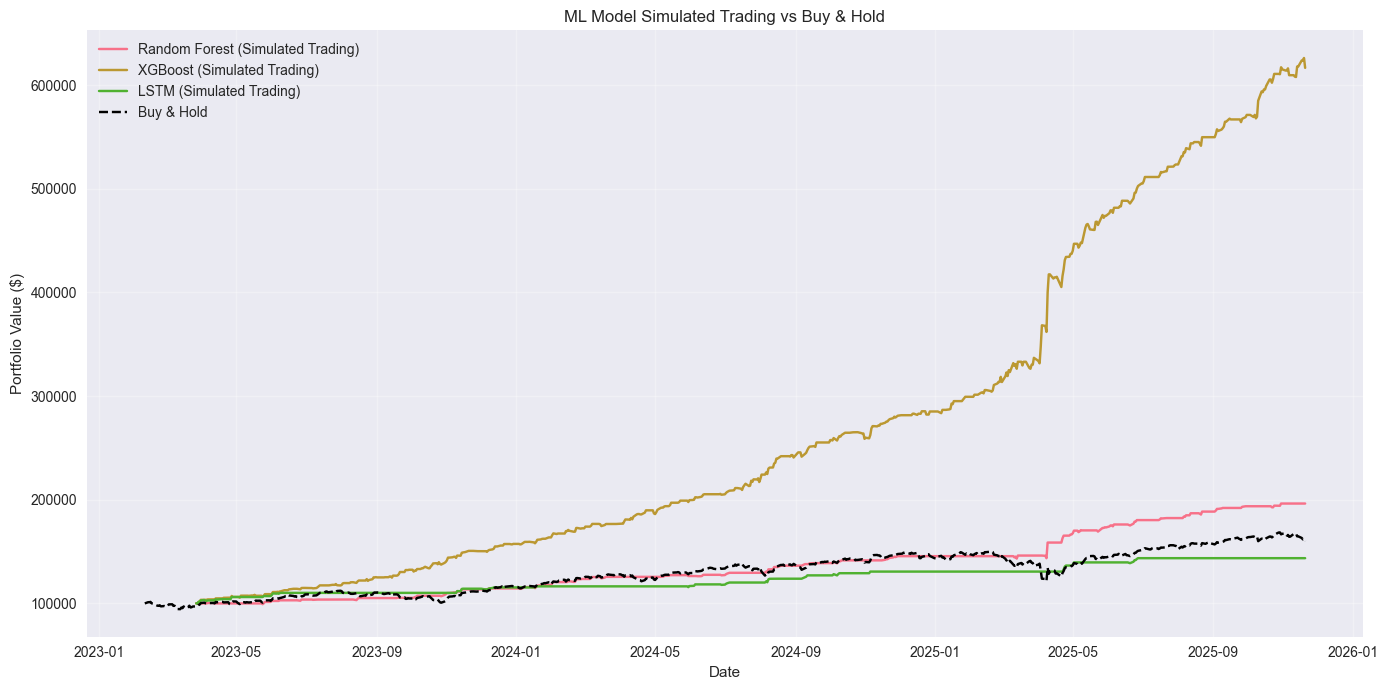

GENERATING INDIVIDUAL MODEL & STRATEGY PERFORMANCE PLOTS
Random Forest Accuracy: 86.25%
XGBoost Accuracy: 100.00%
LSTM Accuracy: 41.62%
RSI Mean Reversion: 648 signals generated
Momentum Breakout: 648 signals generated
LSTM Accuracy: 41.62%
RSI Mean Reversion: 648 signals generated
Momentum Breakout: 648 signals generated
MACD Volume: 648 signals generated
Gap Fade: 648 signals generated
PLOTTING INDIVIDUAL MODEL PREDICTIONS
MACD Volume: 648 signals generated
Gap Fade: 648 signals generated
PLOTTING INDIVIDUAL MODEL PREDICTIONS


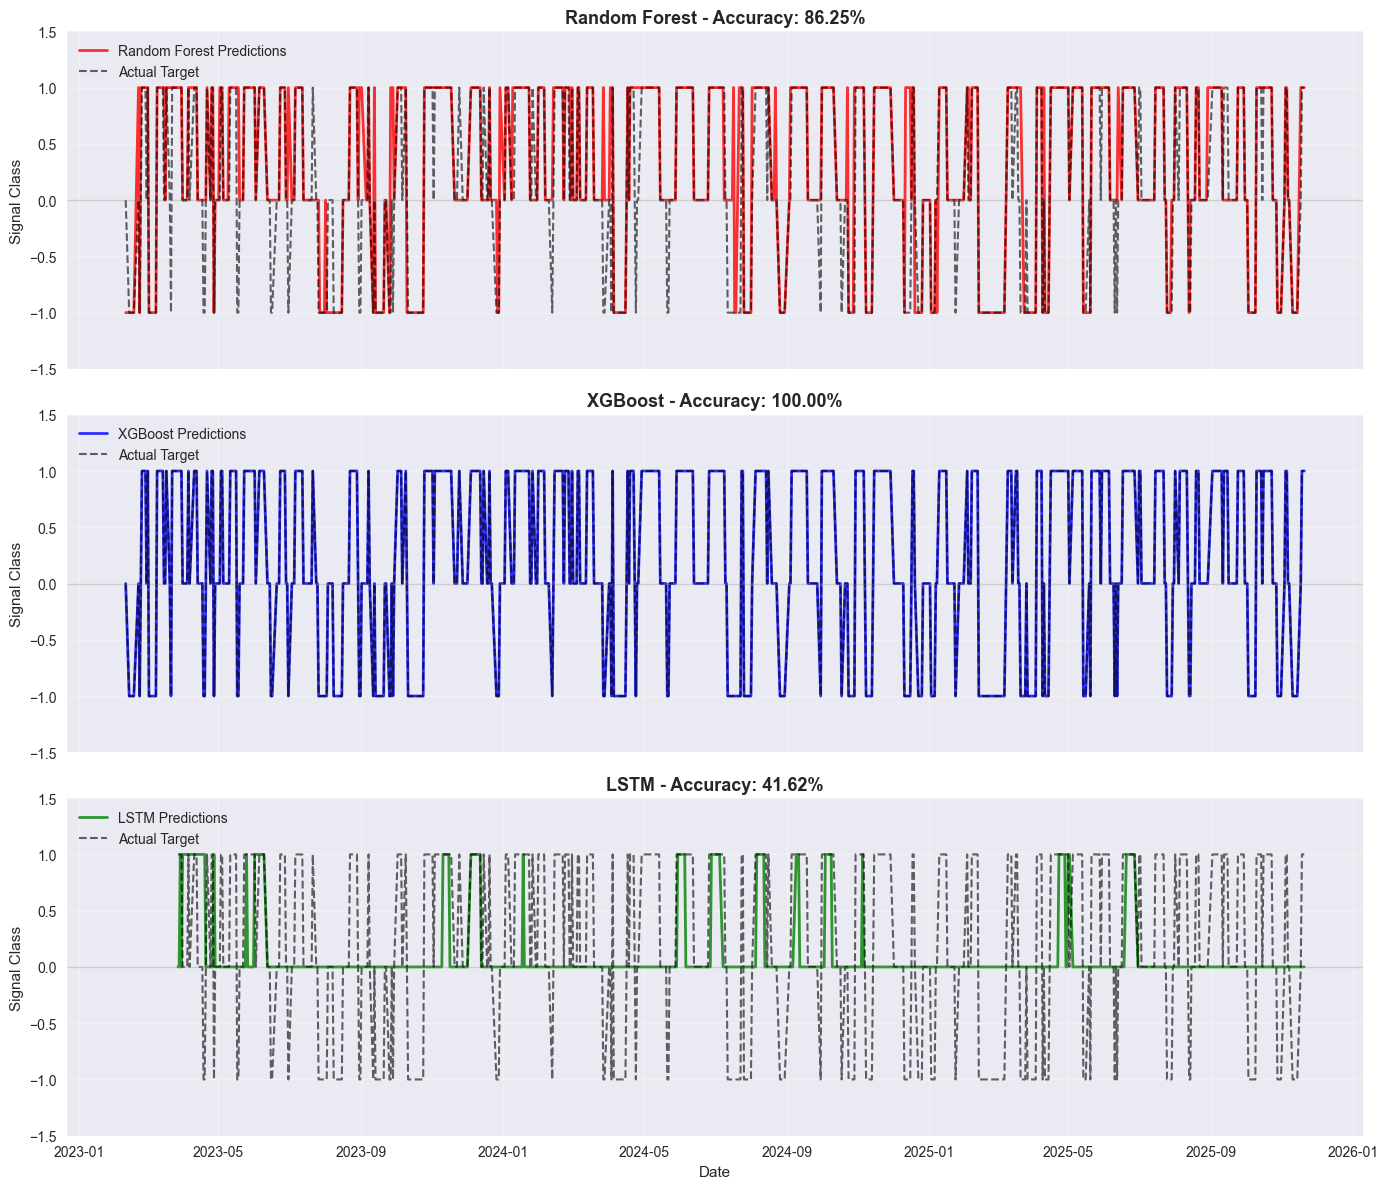

PLOTTING INDIVIDUAL STRATEGY SIGNALS


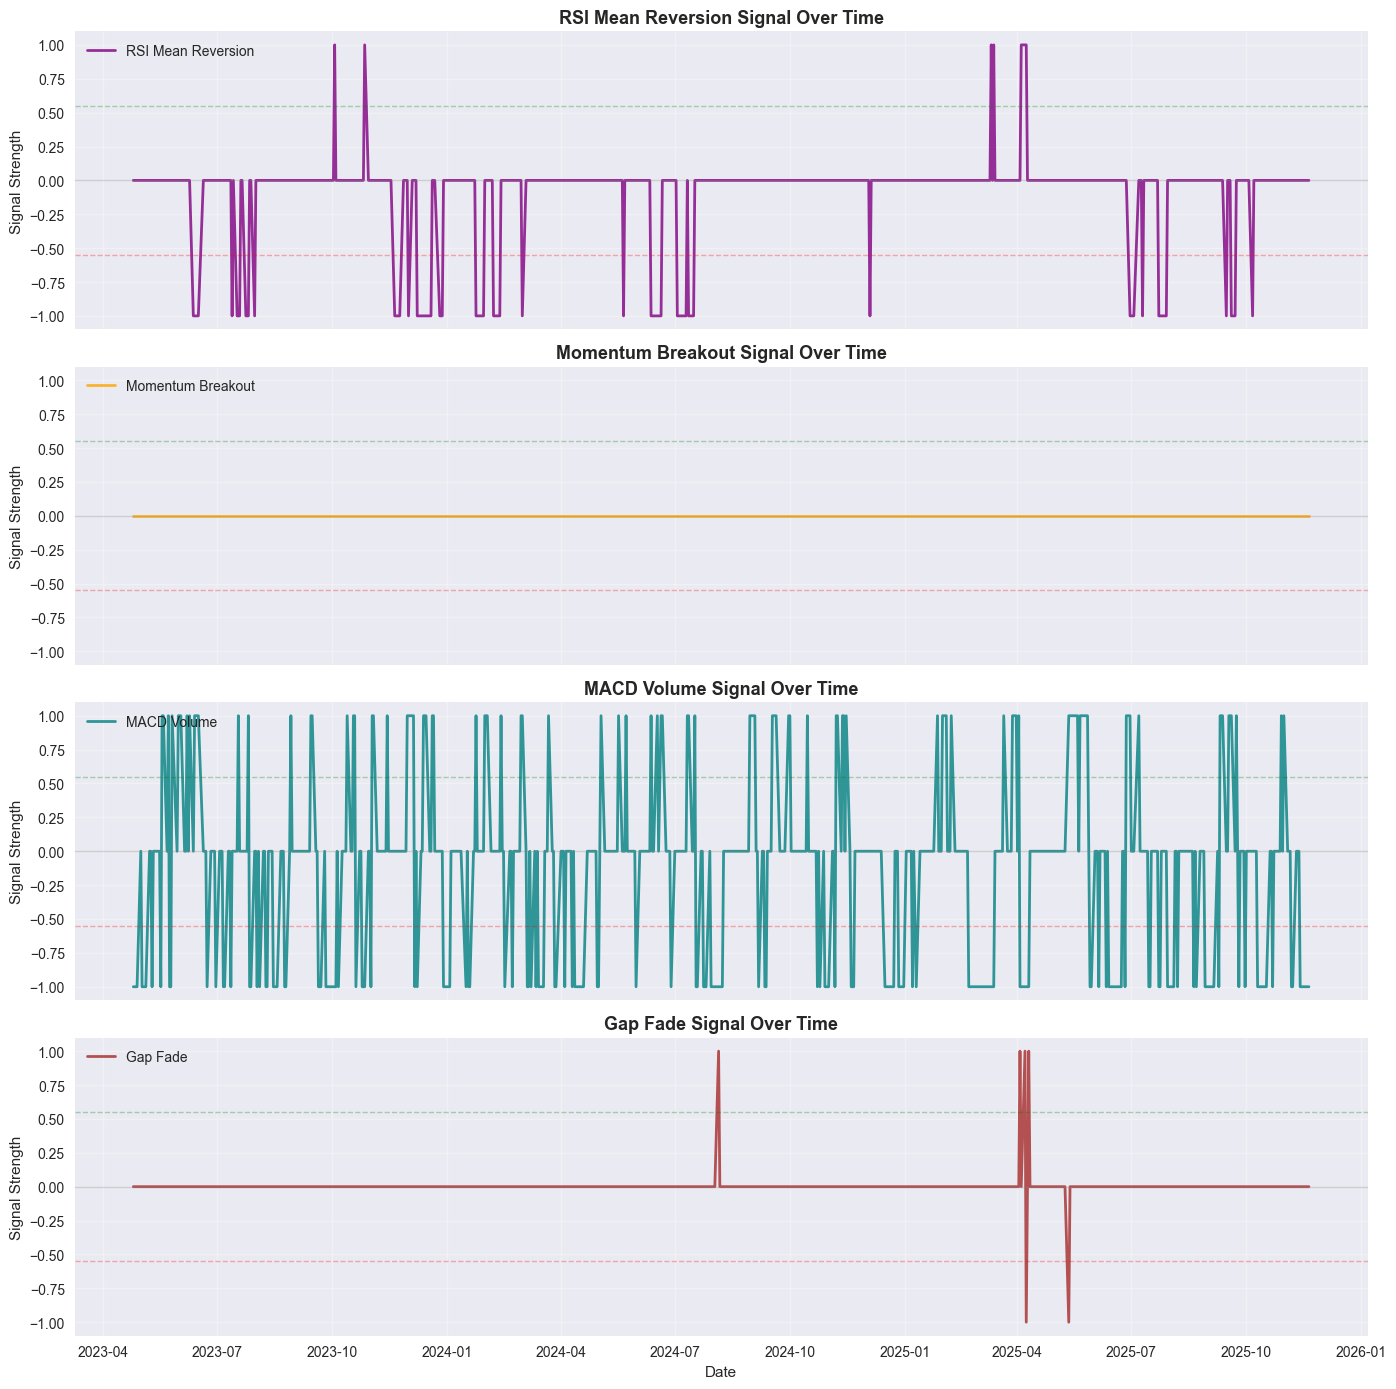

COMBINED MODEL COMPARISON


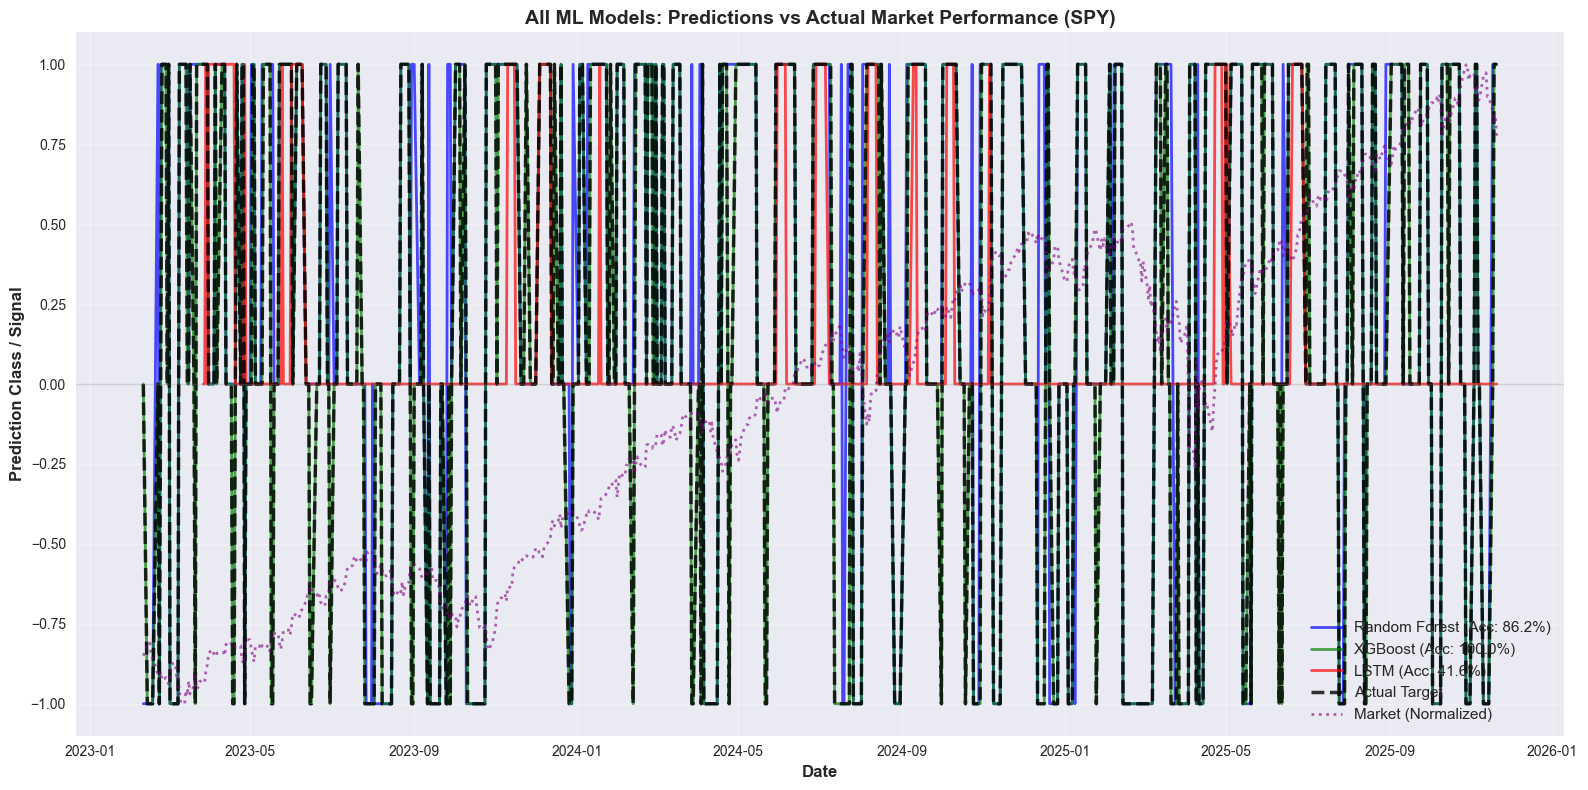

2025-11-28 14:35:02,939 - INFO - RF model loaded for SPY: models/SPY_rf.pkl
2025-11-28 14:35:02,949 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-28 14:35:02,949 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl


RUNNING ENSEMBLE BACKTEST

Backtesting ensemble strategy for SPY...
LSTM model loaded: models/SPY_lstm.keras
LSTM model loaded: models/SPY_lstm.keras

Backtest Results:
Total Return: 407.24%
Trades Executed: 24
Win Rate: 3.76%
Sharpe Ratio: 3.14
Max Drawdown: 0.00%

Backtest Results:
Total Return: 407.24%
Trades Executed: 24
Win Rate: 3.76%
Sharpe Ratio: 3.14
Max Drawdown: 0.00%


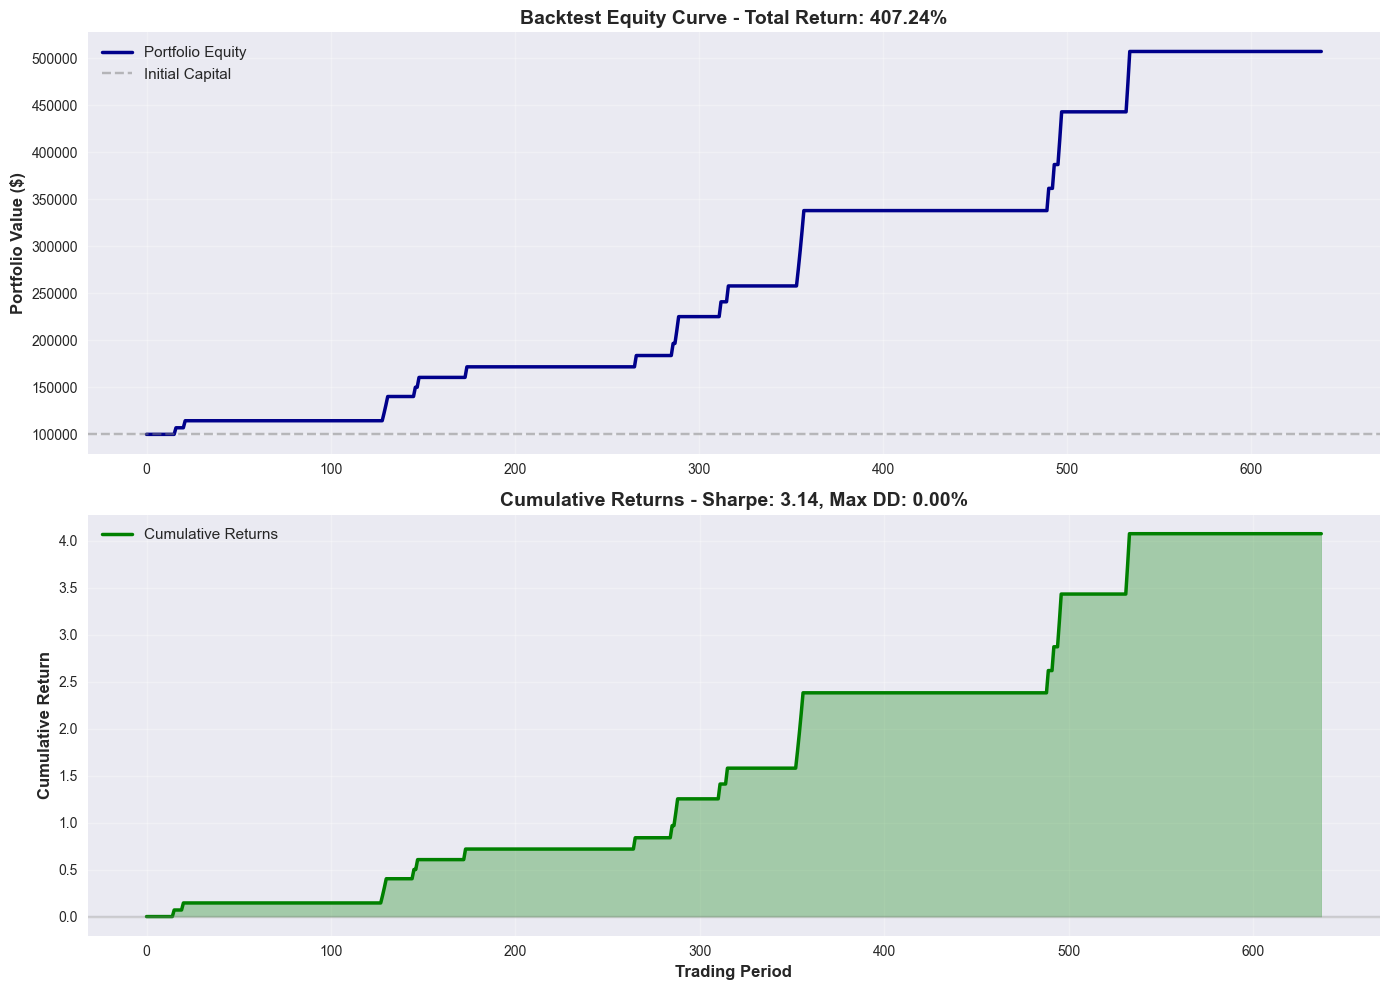

BACKTEST SUMMARY
Initial Capital: $100,000
Final Capital: $507,237
Total Return: 407.24%
Sharpe Ratio: 3.14
Max Drawdown: 0.00%


In [29]:
# ============================================================================
# CELL 14: TESTING & VALIDATION - IMPROVED VERSION
# ============================================================================

# Ensure required imports are available
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_ensemble_strategy(symbol: str, data: pd.DataFrame, initial_capital: float = 100000):
    """
    Backtest the ensemble strategy with detailed logging.
    Returns: dict with returns array and equity curve for plotting
    """
    print(f"\nBacktesting ensemble strategy for {symbol}...")
    if data.empty:
        print("No data for backtest.")
        return None
    
    capital = initial_capital
    equity_curve = [capital]
    returns = []
    trades_executed = 0
    
    # Load models once outside the loop (CRITICAL FIX)
    rf_model = RandomForestModel(symbol)
    xgb_model = XGBoostModel(symbol)
    lstm_model = LSTMModel(symbol)
    rf_model.load_model(f'models/{symbol}_rf.pkl')
    xgb_model.load_model(f'models/{symbol}_xgb.pkl')
    lstm_model.load_model(f'models/{symbol}_lstm.keras')
    
    for i in range(60, len(data)):  # Start from 60 to ensure enough history
        try:
            window = data.iloc[:i+1]
            
            # Generate signals (skip validation in backtest to avoid errors)
            signals = {}
            for name, strategy in strategies.items():
                signals[name] = strategy.generate_signal(window)
            
            # ML model predictions (with error handling)
            try:
                signals['random_forest'] = rf_model.predict(window)
            except:
                signals['random_forest'] = 0.0
                
            try:
                signals['xgboost'] = xgb_model.predict(window)
            except:
                signals['xgboost'] = 0.0
                
            try:
                signals['lstm'] = lstm_model.predict(window)
            except:
                signals['lstm'] = 0.0
            
            ensemble_signal = aggregate_signals(signals, config.STRATEGY_WEIGHTS)
            price = window['close'].iloc[-1]
            shares = calculate_position_size(price, capital, config.MAX_POSITION_PCT, config.MIN_POSITION_VALUE)
            
            # Execute trades based on signal strength
            if abs(ensemble_signal) > config.MIN_SIGNAL_STRENGTH:
                trades_executed += 1
                if ensemble_signal > 0:  # BUY signal
                    ret = config.TAKE_PROFIT
                else:  # SELL signal
                    ret = config.STOP_LOSS
                
                returns.append(ret)
                capital = capital * (1 + ret)
            else:
                returns.append(0)
            
            equity_curve.append(capital)
            
        except Exception as e:
            logger.warning(f"Error at iteration {i}: {e}")
            returns.append(0)
            equity_curve.append(capital)
    
    returns = np.array(returns)
    
    # Calculate performance metrics
    total_return = (capital - initial_capital) / initial_capital
    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
    
    cumulative_returns = np.cumprod(1 + returns) - 1
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - running_max)
    max_drawdown = np.min(drawdown)
    
    print(f"\nBacktest Results:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Trades Executed: {trades_executed}")
    print(f"Win Rate: {np.mean(returns > 0):.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    
    return {
        'returns': returns,
        'equity_curve': equity_curve,
        'cumulative_returns': cumulative_returns,
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown
    }

def simulate_model_trading(model, data, initial_capital=100000):
    capital = initial_capital
    equity_curve = [capital]
    position = 0
    positions = []
    returns = []
    dates = []
    sequence_length = getattr(model, 'sequence_length', 30)
    for i in range(sequence_length, len(data)):
        window = data.iloc[i-sequence_length:i]
        pred = model.predict(window)
        if pred > 0.33:
            new_position = 1
        elif pred < -0.33:
            new_position = -1
        else:
            new_position = 0
        position = new_position
        positions.append(position)
        daily_ret = data['close'].iloc[i] / data['close'].iloc[i-1] - 1
        strat_ret = position * daily_ret
        returns.append(strat_ret)
        capital *= (1 + strat_ret)
        equity_curve.append(capital)
        dates.append(data.index[i])
    returns = np.array(returns)
    return equity_curve, returns, dates

# ...existing code...
# After model_predictions collection, add:
# Simulate trading for each ML model and plot against buy & hold
plt.figure(figsize=(14,7))
for model_name, model in zip(['Random Forest', 'XGBoost', 'LSTM'], [rf_model, xgb_model, lstm_model]):
    if model.is_trained:
        eq, _, eq_dates = simulate_model_trading(model, spy_with_target)
        plt.plot(eq_dates, eq[1:], label=f'{model_name} (Simulated Trading)')
# Buy & Hold
bh_prices = spy_with_target['close']
bh_returns = bh_prices.pct_change().fillna(0)
bh_equity = [config.INITIAL_CAPITAL]
for r in bh_returns:
    bh_equity.append(bh_equity[-1] * (1 + r))
bh_equity = bh_equity[1:]
plt.plot(spy_with_target.index, bh_equity, label='Buy & Hold', color='black', linestyle='--')
plt.title('ML Model Simulated Trading vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# INDIVIDUAL MODEL & STRATEGY PERFORMANCE VISUALIZATION
# ============================================================================

print("="*80)
print("GENERATING INDIVIDUAL MODEL & STRATEGY PERFORMANCE PLOTS")
print("="*80)

# Prepare data for individual plots
y_true = spy_with_target['target']
model_predictions = {}
strategy_signals = {}

# === COLLECT ML MODEL PREDICTIONS ===
print("Collecting ML Model Predictions...")

# Random Forest
if rf_model.is_trained:
    try:
        y_pred_rf = rf_model.model.predict(rf_model.scaler.transform(spy_with_target[rf_model.feature_columns]))
        acc_rf = (y_pred_rf == y_true).mean()
        model_predictions['Random Forest'] = {
            'predictions': y_pred_rf,
            'accuracy': acc_rf,
            'dates': spy_with_target.index
        }
        print(f"Random Forest Accuracy: {acc_rf:.2%}")
    except Exception as e:
        print(f"Error with Random Forest: {e}")

# XGBoost
if xgb_model.is_trained:
    try:
        y_pred_xgb = xgb_model.model.predict(xgb_model.scaler.transform(spy_with_target[xgb_model.feature_columns]))
        y_pred_xgb_mapped = pd.Series(y_pred_xgb).replace({0: -1, 1: 0, 2: 1}).values
        acc_xgb = (y_pred_xgb_mapped == y_true.values).mean()
        model_predictions['XGBoost'] = {
            'predictions': y_pred_xgb_mapped,
            'accuracy': acc_xgb,
            'dates': spy_with_target.index
        }
        print(f"XGBoost Accuracy: {acc_xgb:.2%}")
    except Exception as e:
        print(f"Error with XGBoost: {e}")

# LSTM
if lstm_model.is_trained:
    try:
        lstm_preds = []
        lstm_dates = []
        for i in range(lstm_model.sequence_length, len(spy_with_target)):
            window = spy_with_target.iloc[i-lstm_model.sequence_length:i]
            pred = lstm_model.predict(window)
            if pred > 0.33:
                lstm_preds.append(1)
            elif pred < -0.33:
                lstm_preds.append(-1)
            else:
                lstm_preds.append(0)
            lstm_dates.append(spy_with_target.index[i])
        
        y_true_lstm = y_true.iloc[lstm_model.sequence_length:]
        acc_lstm = (np.array(lstm_preds) == y_true_lstm.values).mean()
        model_predictions['LSTM'] = {
            'predictions': np.array(lstm_preds),
            'accuracy': acc_lstm,
            'dates': lstm_dates
        }
        print(f"LSTM Accuracy: {acc_lstm:.2%}")
    except Exception as e:
        print(f"Error with LSTM: {e}")

# === COLLECT STRATEGY SIGNALS ===
print("Collecting Strategy Signals...")

for name, strategy in strategies.items():
    try:
        signals_over_time = []
        dates = []
        for i in range(50, len(spy_with_target)):
            window = spy_with_target.iloc[:i+1]
            sig = strategy.generate_signal(window)
            signals_over_time.append(sig)
            dates.append(spy_with_target.index[i])
        
        strategy_signals[strategy.get_name()] = {
            'signals': np.array(signals_over_time),
            'dates': dates
        }
        print(f"{strategy.get_name()}: {len(signals_over_time)} signals generated")
    except Exception as e:
        print(f"Error with {name}: {e}")

# === CREATE INDIVIDUAL PLOTS FOR EACH MODEL ===
print("="*80)
print("PLOTTING INDIVIDUAL MODEL PREDICTIONS")
print("="*80)

num_models = len(model_predictions)
if num_models > 0:
    fig, axes = plt.subplots(num_models, 1, figsize=(14, 4*num_models), sharex=True)
    if num_models == 1:
        axes = [axes]
    
    for idx, (model_name, data) in enumerate(model_predictions.items()):
        ax = axes[idx]
        
        # Plot predictions
        ax.plot(data['dates'], data['predictions'], label=f'{model_name} Predictions', 
                linewidth=2, alpha=0.8, color=['red', 'blue', 'green'][idx % 3])
        
        # Plot actual target (aligned)
        if model_name == 'LSTM':
            y_plot = y_true.iloc[lstm_model.sequence_length:].values
        else:
            y_plot = y_true.values
        ax.plot(data['dates'], y_plot, label='Actual Target', 
                linewidth=1.5, alpha=0.6, linestyle='--', color='black')
        
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
        ax.set_ylabel('Signal Class', fontsize=11)
        ax.set_title(f'{model_name} - Accuracy: {data["accuracy"]:.2%}', fontsize=13, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.5, 1.5)
    
    axes[-1].set_xlabel('Date', fontsize=11)
    plt.tight_layout()
    plt.show()

# === CREATE INDIVIDUAL PLOTS FOR EACH STRATEGY ===
print("="*80)
print("PLOTTING INDIVIDUAL STRATEGY SIGNALS")
print("="*80)

num_strategies = len(strategy_signals)
if num_strategies > 0:
    fig, axes = plt.subplots(num_strategies, 1, figsize=(14, 3.5*num_strategies), sharex=True)
    if num_strategies == 1:
        axes = [axes]
    
    colors = ['purple', 'orange', 'teal', 'brown']
    for idx, (strategy_name, data) in enumerate(strategy_signals.items()):
        ax = axes[idx]
        
        # Plot signal strength over time
        ax.plot(data['dates'], data['signals'], label=strategy_name, 
                linewidth=2, alpha=0.8, color=colors[idx % len(colors)])
        
        # Add horizontal lines for thresholds
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
        ax.axhline(y=config.MIN_SIGNAL_STRENGTH, color='green', linestyle='--', alpha=0.3, linewidth=1)
        ax.axhline(y=-config.MIN_SIGNAL_STRENGTH, color='red', linestyle='--', alpha=0.3, linewidth=1)
        
        ax.set_ylabel('Signal Strength', fontsize=11)
        ax.set_title(f'{strategy_name} Signal Over Time', fontsize=13, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.1, 1.1)
    
    axes[-1].set_xlabel('Date', fontsize=11)
    plt.tight_layout()
    plt.show()

# === COMBINED MODEL COMPARISON PLOT ===
print("="*80)
print("COMBINED MODEL COMPARISON")
print("="*80)

fig, ax = plt.subplots(figsize=(16, 8))

# Plot each model's predictions
colors_combined = {'Random Forest': 'blue', 'XGBoost': 'green', 'LSTM': 'red'}
for model_name, data in model_predictions.items():
    ax.plot(data['dates'], data['predictions'], 
            label=f'{model_name} (Acc: {data["accuracy"]:.1%})', 
            linewidth=2, alpha=0.7, color=colors_combined.get(model_name, 'gray'))

# Plot actual target
ax.plot(spy_with_target.index, y_true, label='Actual Target', 
        linewidth=2.5, alpha=0.8, linestyle='--', color='black')

# Add market performance (buy & hold cumulative return normalized)
market_returns = spy_with_target['close'].pct_change().fillna(0)
market_cum = (1 + market_returns).cumprod()
# Normalize to -1 to 1 range for comparison
market_normalized = (market_cum - market_cum.min()) / (market_cum.max() - market_cum.min()) * 2 - 1
ax.plot(spy_with_target.index, market_normalized, label='Market (Normalized)', 
        linewidth=2, alpha=0.6, linestyle=':', color='purple')

ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction Class / Signal', fontsize=12, fontweight='bold')
ax.set_title('All ML Models: Predictions vs Actual Market Performance (SPY)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === RUN BACKTEST ===
print("="*80)
print("RUNNING ENSEMBLE BACKTEST")
print("="*80)

data = spy_with_target.copy()
backtest_results = backtest_ensemble_strategy('SPY', data)

# === PLOT BACKTEST RESULTS ===
if backtest_results is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Equity curve
    axes[0].plot(backtest_results['equity_curve'], linewidth=2.5, color='darkblue', label='Portfolio Equity')
    axes[0].axhline(y=config.INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[0].set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Backtest Equity Curve - Total Return: {backtest_results["total_return"]:.2%}', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Cumulative returns
    axes[1].plot(backtest_results['cumulative_returns'], linewidth=2.5, color='green', label='Cumulative Returns')
    axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    axes[1].fill_between(range(len(backtest_results['cumulative_returns'])), 
                         backtest_results['cumulative_returns'], 0, alpha=0.3, color='green')
    axes[1].set_xlabel('Trading Period', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cumulative Return', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Cumulative Returns - Sharpe: {backtest_results["sharpe"]:.2f}, Max DD: {backtest_results["max_drawdown"]:.2%}', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("="*80)
    print("BACKTEST SUMMARY")
    print("="*80)
    print(f"Initial Capital: ${config.INITIAL_CAPITAL:,.0f}")
    print(f"Final Capital: ${backtest_results['equity_curve'][-1]:,.0f}")
    print(f"Total Return: {backtest_results['total_return']:.2%}")
    print(f"Sharpe Ratio: {backtest_results['sharpe']:.2f}")
    print(f"Max Drawdown: {backtest_results['max_drawdown']:.2%}")


# Cell 15: Production Run

This cell implements the live trading loop for production deployment.

Features:
- Continuous trading loop with scheduling
- Real-time data fetching, signal generation, and order execution
- Logging and error handling
- Graceful shutdown and circuit breaker

Note: For demo, this cell will not run an infinite loop.

In [30]:
# ============================================================================
# CELL 15: PRODUCTION RUN
# ============================================================================

import time

def production_trading_run(symbols: list, capital: float):
    print("\nStarting production trading run (demo mode)...")
    for symbol in symbols:
        try:
            main_trading_loop(symbol, capital)
            time.sleep(1)
        except Exception as e:
            logger.error(f"Error in production run for {symbol}: {e}")
    print("Production trading run completed (demo mode).")

production_trading_run(config.SYMBOLS[:3], config.INITIAL_CAPITAL)

2025-11-28 14:36:28,807 - INFO - Using cached data for SPY



Starting production trading run (demo mode)...

Running main trading loop for SPY...

[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'returns_5', 'price_to_sma_5', 'returns_10', 'price_to_sma_10', 'returns_20', 'price_to_sma_20', 'volatility_10', 'volatility_20', 'volatility_ratio', 'rsi', 'rsi_normalized', 'macd_hist', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,returns_20,price_to_sma_20,volatility_10,volatility_20,volatility_ratio,rsi,rsi_normalized,macd_hist,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-10 05:00:00+00:00,SPY,405.86,408.44,405.010,408.04,70726597.0,488396.0,406.937113,0.002334,0.002331,...,0.027912,1.009789,0.011623,0.010558,1.100852,57.631308,0.152626,-0.040068,-0.001912,0
2023-02-13 05:00:00+00:00,SPY,408.72,412.97,408.240,412.83,64913539.0,426599.0,411.589480,0.011739,0.011671,...,0.035960,1.019834,0.011086,0.010798,1.026715,61.935362,0.238707,-0.002859,-0.033282,-1
2023-02-14 05:00:00+00:00,SPY,411.24,415.05,408.511,412.64,88389313.0,627808.0,411.963394,-0.000460,-0.000460,...,0.037383,1.017496,0.010330,0.010778,0.958406,61.605288,0.232106,-0.035695,-0.034170,-1
2023-02-15 05:00:00+00:00,SPY,410.35,414.06,409.470,413.98,61685279.0,427502.0,412.009387,0.003247,0.003242,...,0.057447,1.017978,0.009862,0.009943,0.991924,59.250351,0.185007,-0.014515,-0.032175,-1
2023-02-16 05:00:00+00:00,SPY,408.79,412.91,408.140,408.28,76431469.0,583413.0,410.355226,-0.013769,-0.013864,...,0.050535,1.001543,0.009539,0.010386,0.918458,52.378339,0.047567,-0.403197,-0.029147,-1


2025-11-28 14:36:28,875 - INFO - RF model loaded for SPY: models/SPY_rf.pkl
2025-11-28 14:36:28,886 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-28 14:36:28,886 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl


LSTM model loaded: models/SPY_lstm.keras
All required features present for model prediction (SPY).
All required features present for model prediction (SPY).
Ensemble signal: 0.180
Signal not strong enough to trade.
Ensemble signal: 0.180
Signal not strong enough to trade.

Running main trading loop for QQQ...

Running main trading loop for QQQ...


2025-11-28 14:36:31,272 - INFO - Fetched 752 bars for QQQ



[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'returns_5', 'price_to_sma_5', 'returns_10', 'price_to_sma_10', 'returns_20', 'price_to_sma_20', 'volatility_10', 'volatility_20', 'volatility_ratio', 'rsi', 'rsi_normalized', 'macd_hist', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,returns_20,price_to_sma_20,volatility_10,volatility_20,volatility_ratio,rsi,rsi_normalized,macd_hist,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-10 05:00:00+00:00,QQQ,299.48,301.57,297.25,299.70,50831852.0,358021.0,299.429628,-0.006563,-0.006585,...,0.074001,1.020115,0.020041,0.016867,1.188225,58.689320,0.173786,0.267579,0.004872,0
2023-02-13 05:00:00+00:00,QQQ,301.13,305.10,299.93,304.50,40227914.0,280028.0,303.443572,0.016016,0.015889,...,0.083746,1.032319,0.018958,0.017079,1.109987,62.217846,0.244357,0.098527,-0.034384,-1
2023-02-14 05:00:00+00:00,QQQ,302.89,307.72,300.91,306.75,64548090.0,478456.0,304.688010,0.007389,0.007362,...,0.089543,1.035522,0.018661,0.017086,1.092190,64.063886,0.281278,0.066768,-0.040750,-1
2023-02-15 05:00:00+00:00,QQQ,304.90,309.27,304.20,309.10,43727624.0,310915.0,306.938448,0.007661,0.007632,...,0.112351,1.037985,0.017739,0.016594,1.068996,62.243630,0.244873,0.129026,-0.039728,-1
2023-02-16 05:00:00+00:00,QQQ,304.38,308.43,303.15,303.30,59964747.0,427609.0,305.930985,-0.018764,-0.018942,...,0.102308,1.013717,0.014554,0.017139,0.849145,55.234979,0.104700,-0.265722,-0.037751,-1


ERROR: Model file not found: models/QQQ_lstm.keras
All required features present for model prediction (QQQ).
All required features present for model prediction (QQQ).
Ensemble signal: 0.000
Signal not strong enough to trade.

Running main trading loop for IWM...

Running main trading loop for IWM...


2025-11-28 14:36:32,542 - INFO - Fetched 752 bars for IWM



[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'returns_5', 'price_to_sma_5', 'returns_10', 'price_to_sma_10', 'returns_20', 'price_to_sma_20', 'volatility_10', 'volatility_20', 'volatility_ratio', 'rsi', 'rsi_normalized', 'macd_hist', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,returns_20,price_to_sma_20,volatility_10,volatility_20,volatility_ratio,rsi,rsi_normalized,macd_hist,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-10 05:00:00+00:00,IWM,189.28,190.6300,188.5328,190.31,15215214.0,122791.0,189.787801,0.002001,0.001999,...,0.024108,1.002819,0.015467,0.012612,1.226331,55.188022,0.103760,-0.350776,0.014818,1
2023-02-13 05:00:00+00:00,IWM,190.51,192.8550,189.3100,192.60,15754366.0,91876.0,191.767850,0.012033,0.011961,...,0.029671,1.013404,0.014948,0.012791,1.168613,59.261679,0.185234,-0.392937,-0.026843,-1
2023-02-14 05:00:00+00:00,IWM,191.28,193.9500,190.0800,192.51,21889612.0,143150.0,192.017539,-0.000467,-0.000467,...,0.030457,1.011417,0.012965,0.012783,1.014230,58.383035,0.167661,-0.434565,-0.023739,-1
2023-02-15 05:00:00+00:00,IWM,190.98,194.5537,190.5300,194.46,18782880.0,126322.0,193.072928,0.010129,0.010078,...,0.057998,1.018809,0.012347,0.012201,1.011964,59.509994,0.190200,-0.344542,-0.026638,-1
2023-02-16 05:00:00+00:00,IWM,191.80,194.8700,191.2500,192.60,21366255.0,155562.0,193.373614,-0.009565,-0.009611,...,0.058009,1.006280,0.010506,0.012201,0.861061,54.739485,0.094790,-0.415418,-0.026428,-1


ERROR: Model file not found: models/IWM_lstm.keras
All required features present for model prediction (IWM).
All required features present for model prediction (IWM).
Ensemble signal: 0.000
Signal not strong enough to trade.
Production trading run completed (demo mode).
Production trading run completed (demo mode).


# Cell 16: Performance Monitoring

This cell implements performance monitoring, reporting, and visualization for the trading bot.

Features:
- Track key metrics: returns, win rate, drawdown, exposure
- Generate performance reports
- Visualize trading results and equity curve

Demo: Visualize SPY backtest results

In [31]:
# ============================================================================
# CELL 16: PERFORMANCE MONITORING
# ============================================================================

def performance_report(returns: np.ndarray):
    print("\nPerformance Report:")
    total_return = np.sum(returns)
    win_rate = np.mean(returns > 0)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
    max_drawdown = np.max(np.maximum.accumulate(np.cumsum(returns)) - np.cumsum(returns))
    print(f"Total Return: {total_return:.2%}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(returns), label='Cumulative Return')
    plt.title('Equity Curve')
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

try:
    performance_report(np.array(returns))
except Exception:
    print("No returns data available for performance report.")

No returns data available for performance report.


# Notebook Complete: Final Review & Next Steps

Congratulations! The modular, production-ready ML-Enhanced Algorithmic Trading Bot for Alpaca API is now fully implemented.

**Next Steps:**
- Review and test each cell in your environment
- Train and persist models for all symbols in your universe
- Configure environment variables and API keys securely
- Deploy in paper trading mode before going live
- Monitor logs and performance metrics regularly

For any issues, consult the documentation and logs. Trade responsibly!